# Aiden Coffey Dinov2 in Digital Pathology

Florida Southern College Student working under Dr. Hoan Ngo 

In [5]:
!pip install dinov2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import seaborn as sns
import math
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA

/home/iambrink/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 20:15:14.619615: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 20:15:14.651119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training Model (Supervised)

In [ ]:
# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the dataset
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number'])  # Drop rows with NaN labels

# Split the data
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Initialize DINOv2 processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Custom Dataset class for DINOv2 preprocessing
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, processor):
        self.dataframe = dataframe
        self.base_path = base_path
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx]['Surgery diagnosis in number'])  # Ensure label is integer

        # Apply DINOv2 preprocessing
        processed = self.processor(images=image, return_tensors="pt")
        image = processed['pixel_values'].squeeze(0)  # Remove batch dimension

        return image, torch.tensor(label, dtype=torch.long)  # Label as long for CrossEntropyLoss

# Create datasets and loaders
train_dataset = CustomDataset(train_df, base_image_path, processor=processor)
test_dataset = CustomDataset(test_df, base_image_path, processor=processor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Custom classifier on top of DINOv2
class DINOClassifier(nn.Module):
    def __init__(self, dinov2_model, num_classes=2):
        super(DINOClassifier, self).__init__()
        self.feature_extractor = dinov2_model
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2 parameters
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DINOClassifier(dinov2_model=feature_extractor).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize placeholders for tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0  

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    #Training 
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions += (predictions == labels).sum().item()

            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    train_acc = correct_predictions / len(train_dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_correct_predictions += (predictions == labels).sum().item()

    val_acc = val_correct_predictions / len(test_dataset)
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_acc)
    val_auc = roc_auc_score(y_true, y_pred)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_Dino_Model_trial_6.pth')
        print(f"Model saved with best validation Acc: {best_val_acc:.4f}")

    # Print metrics for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')

# Training Graphs

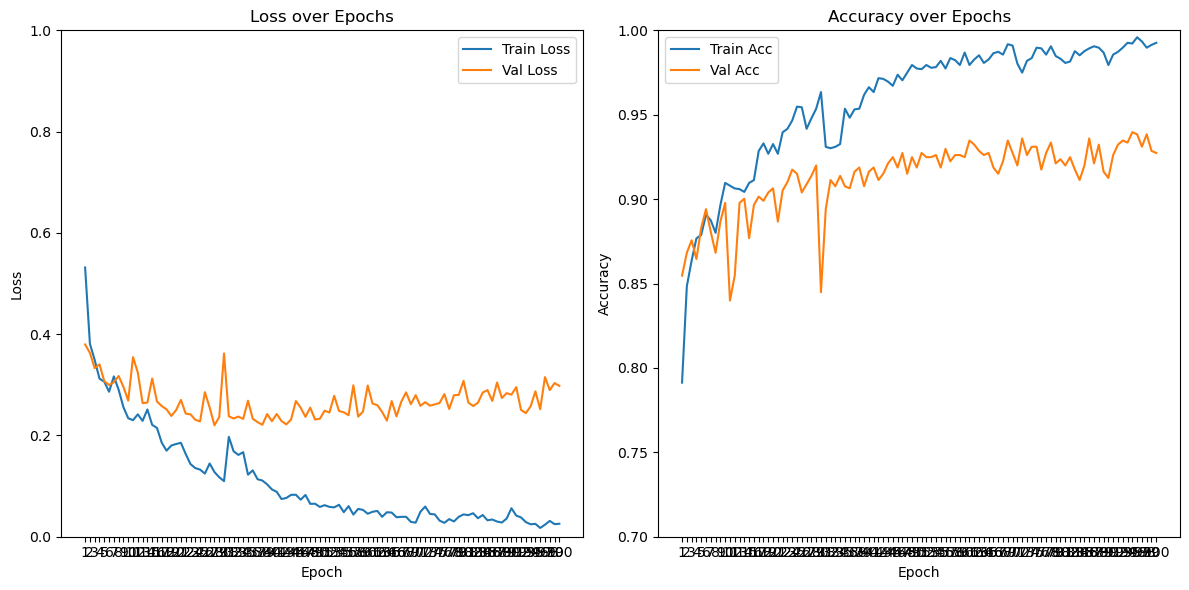

In [ ]:
# Plot training history with standardized y-axis
plt.figure(figsize=(12, 6))

# Calculate the max loss and accuracy for setting y-axis limits
max_loss = max(train_losses + val_losses)
max_acc = max(train_accuracies + val_accuracies)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, math.ceil(max_loss))  # Y-axis from 0 to the ceiling of max_loss
plt.xticks(range(1, num_epochs + 1))  # Epochs on x-axis
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(.7, math.ceil(max_acc))  # Y-axis from 0 to the ceiling of max_acc
plt.xticks(range(1, num_epochs + 1))  # Epochs on x-axis
plt.legend()

plt.tight_layout()
plt.show()



# Testing Evaluation


Final Evaluation Metrics:
  ROC-AUC Score: 0.9753
  Accuracy: 0.9298
  F1 Score: 0.9296
  Precision: 0.9303
  Recall: 0.9298


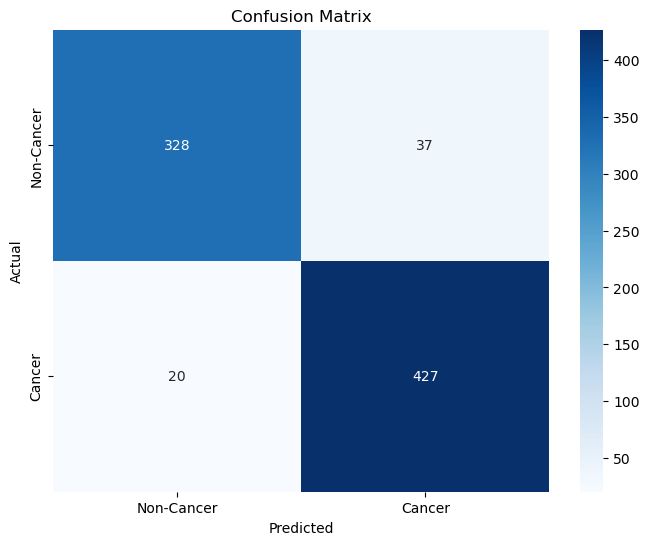

In [29]:
# Reinitialize the processor and base model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Recreate the custom classifier model
class DINOClassifier(nn.Module):
    def __init__(self, dinov2_model, num_classes=2):
        super(DINOClassifier, self).__init__()
        self.feature_extractor = dinov2_model
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2 parameters
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

# Initialize the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DINOClassifier(dinov2_model=feature_extractor).to(device)
# Load the weights
model.load_state_dict(torch.load('/home/iambrink/NOH_Thyroid_Cancer_Data/DINOv2/trial_3/best_Dino_Model_trial_3.pth', map_location=device))


# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluation loop
y_true, y_pred, probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc_score = roc_auc_score(y_true, probs)

print("\nFinal Evaluation Metrics:")
print(f"  ROC-AUC Score: {auc_score:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'], yticklabels=['Non-Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Predict Class 

In [4]:
# Example inference on a new image
def predict(image_path, model, processor, device):
    image = Image.open(image_path).convert('RGB')
    processed = processor(images=image, return_tensors="pt")
    pixel_values = processed['pixel_values'].squeeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(pixel_values.unsqueeze(0))  # Add batch dimension
        prediction = torch.argmax(output, dim=1).item()

    return prediction

# Predict for a new image
image_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg"
prediction = predict(image_path, model, processor, device)
print(f"Predicted Class: {prediction}")


NameError: name 'model' is not defined

# Image Processing With Dino

In [3]:
# Load the DINOv2 model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Define a dataset class for DINOv2 with no labels
class UnsupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_path, processor):
        self.dataframe = dataframe
        self.base_path = base_path
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')

        # Apply DINOv2 preprocessing
        processed = self.processor(images=image, return_tensors="pt")
        image = processed['pixel_values'].squeeze(0)  # Remove batch dimension

        return image  # Return image without label for unsupervised learning

# Create datasets and loaders
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'

df = pd.read_csv(data_path)
df = df.dropna(subset=['image_path'])  # Ensure no missing images
dataset = UnsupervisedDataset(df, base_image_path, processor=processor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# DINOv2 model for unsupervised learning
class DINOFeatureExtractor(torch.nn.Module):
    def __init__(self, dinov2_model):
        super(DINOFeatureExtractor, self).__init__()
        self.feature_extractor = dinov2_model

    def forward(self, x):
        # DINOv2 generates embeddings from the images
        with torch.no_grad():  
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return features

# Initialize the feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DINOFeatureExtractor(dinov2_model=feature_extractor).to(device)

# You can use the model to extract features for clustering or other tasks
# For example, obtaining embeddings for a batch of images
model.eval()
embeddings = []

# Process images
with torch.no_grad():
    for images in tqdm(data_loader, desc="Processing Images", unit="batch"):
        images = images.to(device)
        features = model(images)
        embeddings.append(features.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)


Processing Images: 100%|██████████| 52/52 [05:39<00:00,  6.54s/batch]


# Visualizing Clusters in 2D Using PCA

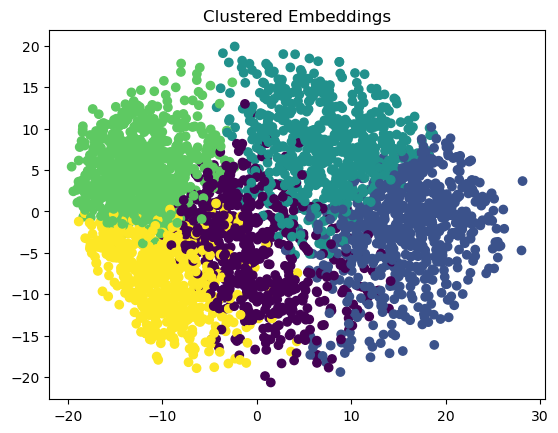

In [4]:
#Apply KMeans clustering on the embeddings
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters
kmeans.fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Plot the first two principal components of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Clustered Embeddings")
plt.show()

# Segment Specific Image

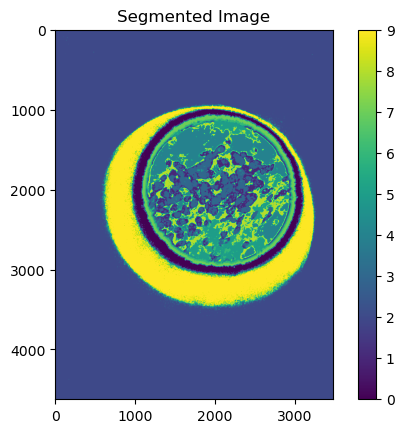

In [5]:
def preprocess_image(image_path):
    # Load the image from the specified path and ensure it's in RGB format.
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image into a NumPy array for further processing.
    image_np = np.array(image)
    
    # Reshape the image array into a 2D array where each row represents a pixel
    # and the 3 columns represent the RGB color values of that pixel.
    image_reshaped = image_np.reshape((-1, 3))  # Reshape to (number_of_pixels, 3)
    
    return image_reshaped, image_np

def segment_image(image_reshaped, n_clusters=5):
    # Initialize the KMeans clustering model with the specified number of clusters (default is 5).
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the KMeans model to the image data. Each pixel is assigned a cluster label.
    kmeans.fit(image_reshaped)
    
    # Retrieve the cluster labels for each pixel.
    labels = kmeans.labels_
    
    return labels

def visualize_segmented_image(labels, image_shape):
    # Reshape the 1D array of labels back into the original image dimensions
    # (height x width) to visualize it as an image.
    segmented_image = labels.reshape(image_shape[:2])
    
    # Show the image
    plt.imshow(segmented_image, cmap='viridis')
    
    # Add a title and other stuff 
    plt.title("Segmented Image")
    plt.colorbar()
    plt.show()


# Main execution
image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg'  # Replace with the path to your image
image_reshaped, image_np = preprocess_image(image_path)

# Apply KMeans segmentation

'''
With this segmentation image here we can define the cluster as any number we want, however
the larger number of clusters the easier and better it is to visualize what the Model is segmenting
if you run an n_clusters=2 you will have a backdrop and a circle for the cell
if you run an n_clusters=10 you will have a detailed representaion of of what your cell looks like and all the niche things our untrained eyes cant see
'''

labels = segment_image(image_reshaped, n_clusters=10)

# Visualize the segmented image
visualize_segmented_image(labels, image_np.shape)


# Cluster Isolation 

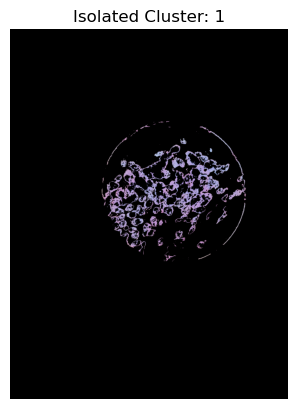

In [8]:
def isolate_cluster(image_np, labels, target_cluster):
    
    # Reshape labels to match image dimensions
    segmented_image = labels.reshape(image_np.shape[:2])
    
    # Create a mask for the target cluster
    mask = (segmented_image == target_cluster).astype(np.uint8)
    
    # Apply the mask to the original image (only retain the target cluster's region)
    isolated_image = image_np * mask[:, :, None]
    
    # Display the isolated cluster
    plt.imshow(isolated_image)
    plt.title(f"Isolated Cluster: {target_cluster}")
    plt.axis("off")
    plt.show()

# Call the function for a specific cluster 
isolate_cluster(image_np, labels, target_cluster=1)


# Segmented Image Over Initial Image

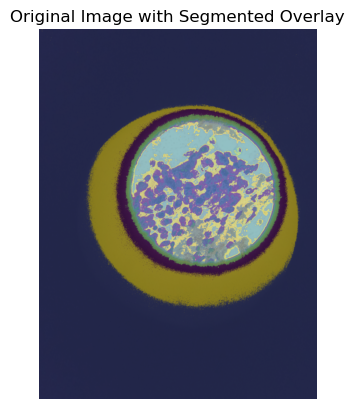

In [7]:
def overlay_segmented_image(image_np, labels, alpha=0.5):
    # Reshape labels to match image dimensions
    segmented_image = labels.reshape(image_np.shape[:2])
    
    # Normalize labels to range [0, 1] for visualization
    normalized_labels = segmented_image / segmented_image.max()
    
    # Use viridis colormap to generate colors for the overlay
    colormap = plt.cm.viridis(normalized_labels)
    
    # Combine the original image with the colormap overlay
    overlay = (1 - alpha) * image_np / 255.0 + alpha * colormap[:, :, :3]
    
    # Display the overlaid image
    plt.imshow(overlay)
    plt.title("Original Image with Segmented Overlay")
    plt.axis("off")
    plt.show()

# Call the function
overlay_segmented_image(image_np, labels)


# Unsupervised Model

In [ ]:
!pip install torchcam

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 1


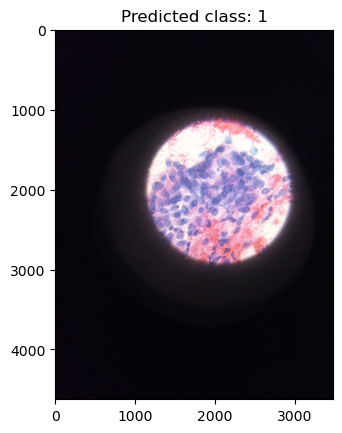

In [43]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained model and image processor
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base")

# Set the model to evaluation mode
model.eval()

# Load an image
img = Image.open("/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg")

# Preprocess the image
inputs = processor(images=img, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()

# Output the predicted class
print(f"Predicted class: {predicted_class}")



# Visualize the image with segmentation
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 0
torch.Size([1, 3, 224, 224])


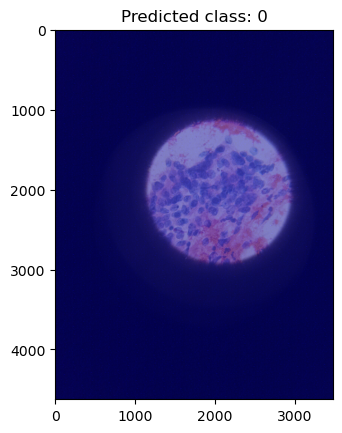

In [19]:
import torch
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained model and image processor
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base")

# Set the model to evaluation mode
model.eval()

# Load an image
img = Image.open("/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg")

# Preprocess the image
inputs = processor(images=img, return_tensors="pt")

# Ensure the image tensor requires gradients
inputs['pixel_values'].requires_grad_()

# Perform inference (this requires gradients for the input)
outputs = model(**inputs)
logits = outputs.logits

# Get the predicted class (the one with the highest logit score)
predicted_class = logits.argmax(-1).item()

# Print predicted class
print(f"Predicted class: {predicted_class}")

# Clear previous gradients
model.zero_grad()

# Backpropagate to get gradients of the predicted class
# Use the logits directly instead of just one logit value
loss = logits[0, predicted_class]  # scalar loss (logit for the predicted class)
loss.backward()

# Get the gradients of the image (i.e., input tensor)
grads = inputs['pixel_values'].grad

# You can also inspect the gradients here if needed
print(grads.shape)  # Check the shape of the gradients

# Get the feature map (adapt this part based on the DINOv2 specifics)
# In DINOv2, you might need to hook into the layers differently as it's based on transformers
# For now, assuming we can use the model output directly for feature maps.

# For now, let's proceed with just the gradients to generate a heatmap.

# Sum gradients along the color channels
grads = grads[0].sum(dim=0).cpu().numpy()  # Sum over all channels for simplicity

# Normalize the gradients
grads = np.maximum(grads, 0)  # ReLU to focus on positive gradients
grads = grads / grads.max()  # Normalize to [0, 1]

# Resize the gradient map to the size of the input image
grads = np.resize(grads, (img.size[1], img.size[0]))

# Visualize the image with the heatmap overlay
plt.imshow(img)
plt.imshow(grads, cmap='jet', alpha=0.5)  # Alpha controls the transparency of the heatmap
plt.title(f"Predicted class: {predicted_class}")
plt.show()


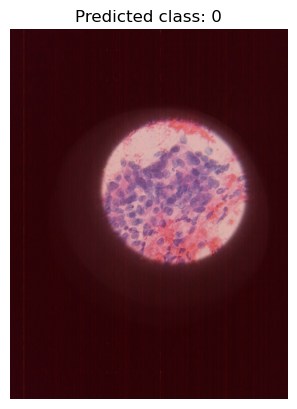

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For applying heatmap

# Function to register the forward hook and get the feature maps
def register_hook(model):
    # Hook function to capture the output of the last layer in the encoder
    def hook_fn(module, input, output):
        global feature_maps
        # Assuming the feature maps are the first element of the output tuple
        feature_maps = output[0]  # Extracting the feature maps
        return None

    # Register the hook on the last transformer layer (12th layer in this case)
    last_transformer_layer = model.dinov2.encoder.layer[-1]
    hook = last_transformer_layer.register_forward_hook(hook_fn)
    return hook

# Generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, inputs, predicted_class):
    model.eval()
    
    # Register the hook
    hook = register_hook(model)
    
    # Zero the gradients before the backward pass
    model.zero_grad()
    
    # Forward pass
    outputs = model(**inputs)
    logits = outputs.logits  # Get the logits
    
    # Get the class probability (predicted class)
    predicted_class = logits.argmax(-1).item()
    loss = logits[0, predicted_class]  # Focus on the predicted class
    
    # Backward pass to get the gradients for the predicted class
    loss.backward()

    # Extract gradients for the input image
    grads = inputs['pixel_values'].grad

    # Compute the mean gradient of each feature map (over all channels)
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])

    # Weight the feature maps by the mean gradients
    for i in range(feature_maps.shape[0]):  # Loop over the channel dimension (instead of feature_maps.shape[1])
        feature_maps[i, :, :] *= pooled_grads[i]  # Adjust for 3D tensor (channels, height, width)

    # Average the weighted feature maps along the channel dimension
    heatmap = torch.mean(feature_maps, dim=0).squeeze()

    # Remove the hook after processing
    hook.remove()

    return heatmap

# Function to visualize the heatmap
def visualize_heatmap(heatmap, img, title):
    # Normalize the heatmap
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)  # Detach and convert to numpy
    heatmap = heatmap / heatmap.max()  # Normalize between 0 and 1
    
    # Resize the heatmap to match the input image size
    heatmap = np.uint8(255 * heatmap)  # Convert to a 0-255 range
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))  # Resize to image size

    # Apply colormap and make sure it's smooth
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Apply Gaussian blur to smooth the heatmap overlay
    heatmap_colored = cv2.GaussianBlur(heatmap_colored, (5, 5), 0)

    # Superimpose the heatmap on the original image
    img_array = np.array(img)
    superimposed_img = cv2.addWeighted(img_array, 0.7, heatmap_colored, 0.3, 0)

    # Display the image with heatmap
    plt.imshow(superimposed_img)
    plt.title(title)
    plt.axis('off')
    plt.show()



# Example usage
img = Image.open("/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg")
inputs = processor(images=img, return_tensors="pt")
inputs['pixel_values'] = inputs['pixel_values'].requires_grad_()  # Ensure gradients are tracked

# Generate Grad-CAM heatmap
heatmap = generate_gradcam_heatmap(model, inputs, predicted_class)

# Visualize the heatmap
visualize_heatmap(heatmap, img, f"Predicted class: {predicted_class}")


# Heat Map With Dino

In [6]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the root directories for NOH and TAN datasets
root_dirs = ["/home/iambrink/NOH_Thyroid_Cancer_Data/NOH", "/home/iambrink/NOH_Thyroid_Cancer_Data/TAN"]

# Function to collect all image paths
def collect_image_paths(root_dirs):
    image_paths = []
    for root_dir in root_dirs:
        for dirpath, _, filenames in os.walk(root_dir):
            for file in filenames:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Filter for image files
                    image_paths.append(os.path.join(dirpath, file))
    return image_paths

# Collect image paths
image_paths = collect_image_paths(root_dirs)
print(f"Found {len(image_paths)} images.")


Found 3325 images.


In [7]:
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from transformers import Dinov2Model
import torch.nn as nn
from torch.optim import AdamW

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define the dataset class
class ThyroidCancerDataset(Dataset):
    def __init__(self, image_paths, transform=None, default_image=None):
        self.image_paths = image_paths
        self.transform = transform
        self.default_image = default_image  # Optional: Default image if one is corrupted

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert("RGB")  # Try opening and converting to RGB
        except OSError as e:
            print(f"Error loading image {img_path}: {e}")
            img = self.default_image  # Replace with a default image or continue to the next one

        if self.transform:
            img = self.transform(img)
        return img, img_path

# Define transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])



In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from transformers import Dinov2Model
from sklearn.metrics import accuracy_score

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the DINOv2 student and teacher models
student_model = Dinov2Model.from_pretrained("facebook/dinov2-base")
teacher_model = Dinov2Model.from_pretrained("facebook/dinov2-base")

# Set teacher model to evaluation mode (no training)
teacher_model.eval()

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to the selected device
student_model.to(device)
teacher_model.to(device)

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-5)
loss_fn = torch.nn.MSELoss()  # Example contrastive loss

num_epochs = 100

In [19]:
best_loss = float('inf')  # Keep track of the best validation loss
patience = 5  # Number of epochs to wait for improvement
no_improve_epochs = 0  # Counter for early stopping

for epoch in range(num_epochs):
    student_model.train()  # Ensure the student model is in training mode
    total_loss = 0

    for batch in train_dataloader:
        images = batch.to(device)  # Move images to the correct device

        # Forward pass for the student model
        student_features = student_model(images).last_hidden_state  # Student's output features

        # Forward pass for the teacher model (no gradients for teacher)
        with torch.no_grad():
            teacher_features = teacher_model(images).last_hidden_state  # Teacher's output features

        # Calculate contrastive loss between student and teacher features
        loss = loss_fn(student_features, teacher_features)

        # Backpropagation for the student model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")


    # Evaluate validation loss
    student_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch in val_dataloader:
            val_images = val_batch
            val_images = val_images.to(device)

            student_features = student_model(val_images).last_hidden_state
            teacher_features = teacher_model(val_images).last_hidden_state

            val_loss = loss_fn(student_features, teacher_features)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(student_model.state_dict(), 'best_student_model2.pth')  # Save the best model
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/100, Loss: 0.018455726017996874
Epoch 1/100, Validation Loss: 0.0286
Epoch 2/100, Loss: 0.01880817640930006
Epoch 2/100, Validation Loss: 0.0323
Epoch 3/100, Loss: 0.01990486611293195
Epoch 3/100, Validation Loss: 0.0278
Epoch 4/100, Loss: 0.018615926513831094
Epoch 4/100, Validation Loss: 0.0285
Epoch 5/100, Loss: 0.017312659588578628
Epoch 5/100, Validation Loss: 0.0331
Epoch 6/100, Loss: 0.016439995651886072
Epoch 6/100, Validation Loss: 0.0291
Epoch 7/100, Loss: 0.015924747012657663
Epoch 7/100, Validation Loss: 0.0279
Epoch 8/100, Loss: 0.01614554106474739
Epoch 8/100, Validation Loss: 0.0299
Early stopping triggered.


In [112]:
# Assuming student_model is a transformer with a final classification head
class StudentModelWithHead(nn.Module):
    def __init__(self, student_model):
        super(StudentModelWithHead, self).__init__()
        self.student_model = student_model
        self.classifier = nn.Linear(student_model.config.hidden_size, 2)  # Binary classification

    def forward(self, x):
        features = self.student_model(x).last_hidden_state
        logits = self.classifier(features[:, 0, :])  # Using the representation of the [CLS] token
        return logits

# After loading the model
student_model = StudentModelWithHead(student_model)
student_model.load_state_dict(torch.load('best_student_model.pth'))


/tmp/ipykernel_5560/930261402.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load('best_student_model.pth'))


RuntimeError: Error(s) in loading state_dict for StudentModelWithHead:
	Missing key(s) in state_dict: "student_model.embeddings.cls_token", "student_model.embeddings.mask_token", "student_model.embeddings.position_embeddings", "student_model.embeddings.patch_embeddings.projection.weight", "student_model.embeddings.patch_embeddings.projection.bias", "student_model.encoder.layer.0.norm1.weight", "student_model.encoder.layer.0.norm1.bias", "student_model.encoder.layer.0.attention.attention.query.weight", "student_model.encoder.layer.0.attention.attention.query.bias", "student_model.encoder.layer.0.attention.attention.key.weight", "student_model.encoder.layer.0.attention.attention.key.bias", "student_model.encoder.layer.0.attention.attention.value.weight", "student_model.encoder.layer.0.attention.attention.value.bias", "student_model.encoder.layer.0.attention.output.dense.weight", "student_model.encoder.layer.0.attention.output.dense.bias", "student_model.encoder.layer.0.layer_scale1.lambda1", "student_model.encoder.layer.0.norm2.weight", "student_model.encoder.layer.0.norm2.bias", "student_model.encoder.layer.0.mlp.fc1.weight", "student_model.encoder.layer.0.mlp.fc1.bias", "student_model.encoder.layer.0.mlp.fc2.weight", "student_model.encoder.layer.0.mlp.fc2.bias", "student_model.encoder.layer.0.layer_scale2.lambda1", "student_model.encoder.layer.1.norm1.weight", "student_model.encoder.layer.1.norm1.bias", "student_model.encoder.layer.1.attention.attention.query.weight", "student_model.encoder.layer.1.attention.attention.query.bias", "student_model.encoder.layer.1.attention.attention.key.weight", "student_model.encoder.layer.1.attention.attention.key.bias", "student_model.encoder.layer.1.attention.attention.value.weight", "student_model.encoder.layer.1.attention.attention.value.bias", "student_model.encoder.layer.1.attention.output.dense.weight", "student_model.encoder.layer.1.attention.output.dense.bias", "student_model.encoder.layer.1.layer_scale1.lambda1", "student_model.encoder.layer.1.norm2.weight", "student_model.encoder.layer.1.norm2.bias", "student_model.encoder.layer.1.mlp.fc1.weight", "student_model.encoder.layer.1.mlp.fc1.bias", "student_model.encoder.layer.1.mlp.fc2.weight", "student_model.encoder.layer.1.mlp.fc2.bias", "student_model.encoder.layer.1.layer_scale2.lambda1", "student_model.encoder.layer.2.norm1.weight", "student_model.encoder.layer.2.norm1.bias", "student_model.encoder.layer.2.attention.attention.query.weight", "student_model.encoder.layer.2.attention.attention.query.bias", "student_model.encoder.layer.2.attention.attention.key.weight", "student_model.encoder.layer.2.attention.attention.key.bias", "student_model.encoder.layer.2.attention.attention.value.weight", "student_model.encoder.layer.2.attention.attention.value.bias", "student_model.encoder.layer.2.attention.output.dense.weight", "student_model.encoder.layer.2.attention.output.dense.bias", "student_model.encoder.layer.2.layer_scale1.lambda1", "student_model.encoder.layer.2.norm2.weight", "student_model.encoder.layer.2.norm2.bias", "student_model.encoder.layer.2.mlp.fc1.weight", "student_model.encoder.layer.2.mlp.fc1.bias", "student_model.encoder.layer.2.mlp.fc2.weight", "student_model.encoder.layer.2.mlp.fc2.bias", "student_model.encoder.layer.2.layer_scale2.lambda1", "student_model.encoder.layer.3.norm1.weight", "student_model.encoder.layer.3.norm1.bias", "student_model.encoder.layer.3.attention.attention.query.weight", "student_model.encoder.layer.3.attention.attention.query.bias", "student_model.encoder.layer.3.attention.attention.key.weight", "student_model.encoder.layer.3.attention.attention.key.bias", "student_model.encoder.layer.3.attention.attention.value.weight", "student_model.encoder.layer.3.attention.attention.value.bias", "student_model.encoder.layer.3.attention.output.dense.weight", "student_model.encoder.layer.3.attention.output.dense.bias", "student_model.encoder.layer.3.layer_scale1.lambda1", "student_model.encoder.layer.3.norm2.weight", "student_model.encoder.layer.3.norm2.bias", "student_model.encoder.layer.3.mlp.fc1.weight", "student_model.encoder.layer.3.mlp.fc1.bias", "student_model.encoder.layer.3.mlp.fc2.weight", "student_model.encoder.layer.3.mlp.fc2.bias", "student_model.encoder.layer.3.layer_scale2.lambda1", "student_model.encoder.layer.4.norm1.weight", "student_model.encoder.layer.4.norm1.bias", "student_model.encoder.layer.4.attention.attention.query.weight", "student_model.encoder.layer.4.attention.attention.query.bias", "student_model.encoder.layer.4.attention.attention.key.weight", "student_model.encoder.layer.4.attention.attention.key.bias", "student_model.encoder.layer.4.attention.attention.value.weight", "student_model.encoder.layer.4.attention.attention.value.bias", "student_model.encoder.layer.4.attention.output.dense.weight", "student_model.encoder.layer.4.attention.output.dense.bias", "student_model.encoder.layer.4.layer_scale1.lambda1", "student_model.encoder.layer.4.norm2.weight", "student_model.encoder.layer.4.norm2.bias", "student_model.encoder.layer.4.mlp.fc1.weight", "student_model.encoder.layer.4.mlp.fc1.bias", "student_model.encoder.layer.4.mlp.fc2.weight", "student_model.encoder.layer.4.mlp.fc2.bias", "student_model.encoder.layer.4.layer_scale2.lambda1", "student_model.encoder.layer.5.norm1.weight", "student_model.encoder.layer.5.norm1.bias", "student_model.encoder.layer.5.attention.attention.query.weight", "student_model.encoder.layer.5.attention.attention.query.bias", "student_model.encoder.layer.5.attention.attention.key.weight", "student_model.encoder.layer.5.attention.attention.key.bias", "student_model.encoder.layer.5.attention.attention.value.weight", "student_model.encoder.layer.5.attention.attention.value.bias", "student_model.encoder.layer.5.attention.output.dense.weight", "student_model.encoder.layer.5.attention.output.dense.bias", "student_model.encoder.layer.5.layer_scale1.lambda1", "student_model.encoder.layer.5.norm2.weight", "student_model.encoder.layer.5.norm2.bias", "student_model.encoder.layer.5.mlp.fc1.weight", "student_model.encoder.layer.5.mlp.fc1.bias", "student_model.encoder.layer.5.mlp.fc2.weight", "student_model.encoder.layer.5.mlp.fc2.bias", "student_model.encoder.layer.5.layer_scale2.lambda1", "student_model.encoder.layer.6.norm1.weight", "student_model.encoder.layer.6.norm1.bias", "student_model.encoder.layer.6.attention.attention.query.weight", "student_model.encoder.layer.6.attention.attention.query.bias", "student_model.encoder.layer.6.attention.attention.key.weight", "student_model.encoder.layer.6.attention.attention.key.bias", "student_model.encoder.layer.6.attention.attention.value.weight", "student_model.encoder.layer.6.attention.attention.value.bias", "student_model.encoder.layer.6.attention.output.dense.weight", "student_model.encoder.layer.6.attention.output.dense.bias", "student_model.encoder.layer.6.layer_scale1.lambda1", "student_model.encoder.layer.6.norm2.weight", "student_model.encoder.layer.6.norm2.bias", "student_model.encoder.layer.6.mlp.fc1.weight", "student_model.encoder.layer.6.mlp.fc1.bias", "student_model.encoder.layer.6.mlp.fc2.weight", "student_model.encoder.layer.6.mlp.fc2.bias", "student_model.encoder.layer.6.layer_scale2.lambda1", "student_model.encoder.layer.7.norm1.weight", "student_model.encoder.layer.7.norm1.bias", "student_model.encoder.layer.7.attention.attention.query.weight", "student_model.encoder.layer.7.attention.attention.query.bias", "student_model.encoder.layer.7.attention.attention.key.weight", "student_model.encoder.layer.7.attention.attention.key.bias", "student_model.encoder.layer.7.attention.attention.value.weight", "student_model.encoder.layer.7.attention.attention.value.bias", "student_model.encoder.layer.7.attention.output.dense.weight", "student_model.encoder.layer.7.attention.output.dense.bias", "student_model.encoder.layer.7.layer_scale1.lambda1", "student_model.encoder.layer.7.norm2.weight", "student_model.encoder.layer.7.norm2.bias", "student_model.encoder.layer.7.mlp.fc1.weight", "student_model.encoder.layer.7.mlp.fc1.bias", "student_model.encoder.layer.7.mlp.fc2.weight", "student_model.encoder.layer.7.mlp.fc2.bias", "student_model.encoder.layer.7.layer_scale2.lambda1", "student_model.encoder.layer.8.norm1.weight", "student_model.encoder.layer.8.norm1.bias", "student_model.encoder.layer.8.attention.attention.query.weight", "student_model.encoder.layer.8.attention.attention.query.bias", "student_model.encoder.layer.8.attention.attention.key.weight", "student_model.encoder.layer.8.attention.attention.key.bias", "student_model.encoder.layer.8.attention.attention.value.weight", "student_model.encoder.layer.8.attention.attention.value.bias", "student_model.encoder.layer.8.attention.output.dense.weight", "student_model.encoder.layer.8.attention.output.dense.bias", "student_model.encoder.layer.8.layer_scale1.lambda1", "student_model.encoder.layer.8.norm2.weight", "student_model.encoder.layer.8.norm2.bias", "student_model.encoder.layer.8.mlp.fc1.weight", "student_model.encoder.layer.8.mlp.fc1.bias", "student_model.encoder.layer.8.mlp.fc2.weight", "student_model.encoder.layer.8.mlp.fc2.bias", "student_model.encoder.layer.8.layer_scale2.lambda1", "student_model.encoder.layer.9.norm1.weight", "student_model.encoder.layer.9.norm1.bias", "student_model.encoder.layer.9.attention.attention.query.weight", "student_model.encoder.layer.9.attention.attention.query.bias", "student_model.encoder.layer.9.attention.attention.key.weight", "student_model.encoder.layer.9.attention.attention.key.bias", "student_model.encoder.layer.9.attention.attention.value.weight", "student_model.encoder.layer.9.attention.attention.value.bias", "student_model.encoder.layer.9.attention.output.dense.weight", "student_model.encoder.layer.9.attention.output.dense.bias", "student_model.encoder.layer.9.layer_scale1.lambda1", "student_model.encoder.layer.9.norm2.weight", "student_model.encoder.layer.9.norm2.bias", "student_model.encoder.layer.9.mlp.fc1.weight", "student_model.encoder.layer.9.mlp.fc1.bias", "student_model.encoder.layer.9.mlp.fc2.weight", "student_model.encoder.layer.9.mlp.fc2.bias", "student_model.encoder.layer.9.layer_scale2.lambda1", "student_model.encoder.layer.10.norm1.weight", "student_model.encoder.layer.10.norm1.bias", "student_model.encoder.layer.10.attention.attention.query.weight", "student_model.encoder.layer.10.attention.attention.query.bias", "student_model.encoder.layer.10.attention.attention.key.weight", "student_model.encoder.layer.10.attention.attention.key.bias", "student_model.encoder.layer.10.attention.attention.value.weight", "student_model.encoder.layer.10.attention.attention.value.bias", "student_model.encoder.layer.10.attention.output.dense.weight", "student_model.encoder.layer.10.attention.output.dense.bias", "student_model.encoder.layer.10.layer_scale1.lambda1", "student_model.encoder.layer.10.norm2.weight", "student_model.encoder.layer.10.norm2.bias", "student_model.encoder.layer.10.mlp.fc1.weight", "student_model.encoder.layer.10.mlp.fc1.bias", "student_model.encoder.layer.10.mlp.fc2.weight", "student_model.encoder.layer.10.mlp.fc2.bias", "student_model.encoder.layer.10.layer_scale2.lambda1", "student_model.encoder.layer.11.norm1.weight", "student_model.encoder.layer.11.norm1.bias", "student_model.encoder.layer.11.attention.attention.query.weight", "student_model.encoder.layer.11.attention.attention.query.bias", "student_model.encoder.layer.11.attention.attention.key.weight", "student_model.encoder.layer.11.attention.attention.key.bias", "student_model.encoder.layer.11.attention.attention.value.weight", "student_model.encoder.layer.11.attention.attention.value.bias", "student_model.encoder.layer.11.attention.output.dense.weight", "student_model.encoder.layer.11.attention.output.dense.bias", "student_model.encoder.layer.11.layer_scale1.lambda1", "student_model.encoder.layer.11.norm2.weight", "student_model.encoder.layer.11.norm2.bias", "student_model.encoder.layer.11.mlp.fc1.weight", "student_model.encoder.layer.11.mlp.fc1.bias", "student_model.encoder.layer.11.mlp.fc2.weight", "student_model.encoder.layer.11.mlp.fc2.bias", "student_model.encoder.layer.11.layer_scale2.lambda1", "student_model.layernorm.weight", "student_model.layernorm.bias". 
	Unexpected key(s) in state_dict: "dinov2.embeddings.cls_token", "dinov2.embeddings.mask_token", "dinov2.embeddings.position_embeddings", "dinov2.embeddings.patch_embeddings.projection.weight", "dinov2.embeddings.patch_embeddings.projection.bias", "dinov2.encoder.layer.0.norm1.weight", "dinov2.encoder.layer.0.norm1.bias", "dinov2.encoder.layer.0.attention.attention.query.weight", "dinov2.encoder.layer.0.attention.attention.query.bias", "dinov2.encoder.layer.0.attention.attention.key.weight", "dinov2.encoder.layer.0.attention.attention.key.bias", "dinov2.encoder.layer.0.attention.attention.value.weight", "dinov2.encoder.layer.0.attention.attention.value.bias", "dinov2.encoder.layer.0.attention.output.dense.weight", "dinov2.encoder.layer.0.attention.output.dense.bias", "dinov2.encoder.layer.0.layer_scale1.lambda1", "dinov2.encoder.layer.0.norm2.weight", "dinov2.encoder.layer.0.norm2.bias", "dinov2.encoder.layer.0.mlp.fc1.weight", "dinov2.encoder.layer.0.mlp.fc1.bias", "dinov2.encoder.layer.0.mlp.fc2.weight", "dinov2.encoder.layer.0.mlp.fc2.bias", "dinov2.encoder.layer.0.layer_scale2.lambda1", "dinov2.encoder.layer.1.norm1.weight", "dinov2.encoder.layer.1.norm1.bias", "dinov2.encoder.layer.1.attention.attention.query.weight", "dinov2.encoder.layer.1.attention.attention.query.bias", "dinov2.encoder.layer.1.attention.attention.key.weight", "dinov2.encoder.layer.1.attention.attention.key.bias", "dinov2.encoder.layer.1.attention.attention.value.weight", "dinov2.encoder.layer.1.attention.attention.value.bias", "dinov2.encoder.layer.1.attention.output.dense.weight", "dinov2.encoder.layer.1.attention.output.dense.bias", "dinov2.encoder.layer.1.layer_scale1.lambda1", "dinov2.encoder.layer.1.norm2.weight", "dinov2.encoder.layer.1.norm2.bias", "dinov2.encoder.layer.1.mlp.fc1.weight", "dinov2.encoder.layer.1.mlp.fc1.bias", "dinov2.encoder.layer.1.mlp.fc2.weight", "dinov2.encoder.layer.1.mlp.fc2.bias", "dinov2.encoder.layer.1.layer_scale2.lambda1", "dinov2.encoder.layer.2.norm1.weight", "dinov2.encoder.layer.2.norm1.bias", "dinov2.encoder.layer.2.attention.attention.query.weight", "dinov2.encoder.layer.2.attention.attention.query.bias", "dinov2.encoder.layer.2.attention.attention.key.weight", "dinov2.encoder.layer.2.attention.attention.key.bias", "dinov2.encoder.layer.2.attention.attention.value.weight", "dinov2.encoder.layer.2.attention.attention.value.bias", "dinov2.encoder.layer.2.attention.output.dense.weight", "dinov2.encoder.layer.2.attention.output.dense.bias", "dinov2.encoder.layer.2.layer_scale1.lambda1", "dinov2.encoder.layer.2.norm2.weight", "dinov2.encoder.layer.2.norm2.bias", "dinov2.encoder.layer.2.mlp.fc1.weight", "dinov2.encoder.layer.2.mlp.fc1.bias", "dinov2.encoder.layer.2.mlp.fc2.weight", "dinov2.encoder.layer.2.mlp.fc2.bias", "dinov2.encoder.layer.2.layer_scale2.lambda1", "dinov2.encoder.layer.3.norm1.weight", "dinov2.encoder.layer.3.norm1.bias", "dinov2.encoder.layer.3.attention.attention.query.weight", "dinov2.encoder.layer.3.attention.attention.query.bias", "dinov2.encoder.layer.3.attention.attention.key.weight", "dinov2.encoder.layer.3.attention.attention.key.bias", "dinov2.encoder.layer.3.attention.attention.value.weight", "dinov2.encoder.layer.3.attention.attention.value.bias", "dinov2.encoder.layer.3.attention.output.dense.weight", "dinov2.encoder.layer.3.attention.output.dense.bias", "dinov2.encoder.layer.3.layer_scale1.lambda1", "dinov2.encoder.layer.3.norm2.weight", "dinov2.encoder.layer.3.norm2.bias", "dinov2.encoder.layer.3.mlp.fc1.weight", "dinov2.encoder.layer.3.mlp.fc1.bias", "dinov2.encoder.layer.3.mlp.fc2.weight", "dinov2.encoder.layer.3.mlp.fc2.bias", "dinov2.encoder.layer.3.layer_scale2.lambda1", "dinov2.encoder.layer.4.norm1.weight", "dinov2.encoder.layer.4.norm1.bias", "dinov2.encoder.layer.4.attention.attention.query.weight", "dinov2.encoder.layer.4.attention.attention.query.bias", "dinov2.encoder.layer.4.attention.attention.key.weight", "dinov2.encoder.layer.4.attention.attention.key.bias", "dinov2.encoder.layer.4.attention.attention.value.weight", "dinov2.encoder.layer.4.attention.attention.value.bias", "dinov2.encoder.layer.4.attention.output.dense.weight", "dinov2.encoder.layer.4.attention.output.dense.bias", "dinov2.encoder.layer.4.layer_scale1.lambda1", "dinov2.encoder.layer.4.norm2.weight", "dinov2.encoder.layer.4.norm2.bias", "dinov2.encoder.layer.4.mlp.fc1.weight", "dinov2.encoder.layer.4.mlp.fc1.bias", "dinov2.encoder.layer.4.mlp.fc2.weight", "dinov2.encoder.layer.4.mlp.fc2.bias", "dinov2.encoder.layer.4.layer_scale2.lambda1", "dinov2.encoder.layer.5.norm1.weight", "dinov2.encoder.layer.5.norm1.bias", "dinov2.encoder.layer.5.attention.attention.query.weight", "dinov2.encoder.layer.5.attention.attention.query.bias", "dinov2.encoder.layer.5.attention.attention.key.weight", "dinov2.encoder.layer.5.attention.attention.key.bias", "dinov2.encoder.layer.5.attention.attention.value.weight", "dinov2.encoder.layer.5.attention.attention.value.bias", "dinov2.encoder.layer.5.attention.output.dense.weight", "dinov2.encoder.layer.5.attention.output.dense.bias", "dinov2.encoder.layer.5.layer_scale1.lambda1", "dinov2.encoder.layer.5.norm2.weight", "dinov2.encoder.layer.5.norm2.bias", "dinov2.encoder.layer.5.mlp.fc1.weight", "dinov2.encoder.layer.5.mlp.fc1.bias", "dinov2.encoder.layer.5.mlp.fc2.weight", "dinov2.encoder.layer.5.mlp.fc2.bias", "dinov2.encoder.layer.5.layer_scale2.lambda1", "dinov2.encoder.layer.6.norm1.weight", "dinov2.encoder.layer.6.norm1.bias", "dinov2.encoder.layer.6.attention.attention.query.weight", "dinov2.encoder.layer.6.attention.attention.query.bias", "dinov2.encoder.layer.6.attention.attention.key.weight", "dinov2.encoder.layer.6.attention.attention.key.bias", "dinov2.encoder.layer.6.attention.attention.value.weight", "dinov2.encoder.layer.6.attention.attention.value.bias", "dinov2.encoder.layer.6.attention.output.dense.weight", "dinov2.encoder.layer.6.attention.output.dense.bias", "dinov2.encoder.layer.6.layer_scale1.lambda1", "dinov2.encoder.layer.6.norm2.weight", "dinov2.encoder.layer.6.norm2.bias", "dinov2.encoder.layer.6.mlp.fc1.weight", "dinov2.encoder.layer.6.mlp.fc1.bias", "dinov2.encoder.layer.6.mlp.fc2.weight", "dinov2.encoder.layer.6.mlp.fc2.bias", "dinov2.encoder.layer.6.layer_scale2.lambda1", "dinov2.encoder.layer.7.norm1.weight", "dinov2.encoder.layer.7.norm1.bias", "dinov2.encoder.layer.7.attention.attention.query.weight", "dinov2.encoder.layer.7.attention.attention.query.bias", "dinov2.encoder.layer.7.attention.attention.key.weight", "dinov2.encoder.layer.7.attention.attention.key.bias", "dinov2.encoder.layer.7.attention.attention.value.weight", "dinov2.encoder.layer.7.attention.attention.value.bias", "dinov2.encoder.layer.7.attention.output.dense.weight", "dinov2.encoder.layer.7.attention.output.dense.bias", "dinov2.encoder.layer.7.layer_scale1.lambda1", "dinov2.encoder.layer.7.norm2.weight", "dinov2.encoder.layer.7.norm2.bias", "dinov2.encoder.layer.7.mlp.fc1.weight", "dinov2.encoder.layer.7.mlp.fc1.bias", "dinov2.encoder.layer.7.mlp.fc2.weight", "dinov2.encoder.layer.7.mlp.fc2.bias", "dinov2.encoder.layer.7.layer_scale2.lambda1", "dinov2.encoder.layer.8.norm1.weight", "dinov2.encoder.layer.8.norm1.bias", "dinov2.encoder.layer.8.attention.attention.query.weight", "dinov2.encoder.layer.8.attention.attention.query.bias", "dinov2.encoder.layer.8.attention.attention.key.weight", "dinov2.encoder.layer.8.attention.attention.key.bias", "dinov2.encoder.layer.8.attention.attention.value.weight", "dinov2.encoder.layer.8.attention.attention.value.bias", "dinov2.encoder.layer.8.attention.output.dense.weight", "dinov2.encoder.layer.8.attention.output.dense.bias", "dinov2.encoder.layer.8.layer_scale1.lambda1", "dinov2.encoder.layer.8.norm2.weight", "dinov2.encoder.layer.8.norm2.bias", "dinov2.encoder.layer.8.mlp.fc1.weight", "dinov2.encoder.layer.8.mlp.fc1.bias", "dinov2.encoder.layer.8.mlp.fc2.weight", "dinov2.encoder.layer.8.mlp.fc2.bias", "dinov2.encoder.layer.8.layer_scale2.lambda1", "dinov2.encoder.layer.9.norm1.weight", "dinov2.encoder.layer.9.norm1.bias", "dinov2.encoder.layer.9.attention.attention.query.weight", "dinov2.encoder.layer.9.attention.attention.query.bias", "dinov2.encoder.layer.9.attention.attention.key.weight", "dinov2.encoder.layer.9.attention.attention.key.bias", "dinov2.encoder.layer.9.attention.attention.value.weight", "dinov2.encoder.layer.9.attention.attention.value.bias", "dinov2.encoder.layer.9.attention.output.dense.weight", "dinov2.encoder.layer.9.attention.output.dense.bias", "dinov2.encoder.layer.9.layer_scale1.lambda1", "dinov2.encoder.layer.9.norm2.weight", "dinov2.encoder.layer.9.norm2.bias", "dinov2.encoder.layer.9.mlp.fc1.weight", "dinov2.encoder.layer.9.mlp.fc1.bias", "dinov2.encoder.layer.9.mlp.fc2.weight", "dinov2.encoder.layer.9.mlp.fc2.bias", "dinov2.encoder.layer.9.layer_scale2.lambda1", "dinov2.encoder.layer.10.norm1.weight", "dinov2.encoder.layer.10.norm1.bias", "dinov2.encoder.layer.10.attention.attention.query.weight", "dinov2.encoder.layer.10.attention.attention.query.bias", "dinov2.encoder.layer.10.attention.attention.key.weight", "dinov2.encoder.layer.10.attention.attention.key.bias", "dinov2.encoder.layer.10.attention.attention.value.weight", "dinov2.encoder.layer.10.attention.attention.value.bias", "dinov2.encoder.layer.10.attention.output.dense.weight", "dinov2.encoder.layer.10.attention.output.dense.bias", "dinov2.encoder.layer.10.layer_scale1.lambda1", "dinov2.encoder.layer.10.norm2.weight", "dinov2.encoder.layer.10.norm2.bias", "dinov2.encoder.layer.10.mlp.fc1.weight", "dinov2.encoder.layer.10.mlp.fc1.bias", "dinov2.encoder.layer.10.mlp.fc2.weight", "dinov2.encoder.layer.10.mlp.fc2.bias", "dinov2.encoder.layer.10.layer_scale2.lambda1", "dinov2.encoder.layer.11.norm1.weight", "dinov2.encoder.layer.11.norm1.bias", "dinov2.encoder.layer.11.attention.attention.query.weight", "dinov2.encoder.layer.11.attention.attention.query.bias", "dinov2.encoder.layer.11.attention.attention.key.weight", "dinov2.encoder.layer.11.attention.attention.key.bias", "dinov2.encoder.layer.11.attention.attention.value.weight", "dinov2.encoder.layer.11.attention.attention.value.bias", "dinov2.encoder.layer.11.attention.output.dense.weight", "dinov2.encoder.layer.11.attention.output.dense.bias", "dinov2.encoder.layer.11.layer_scale1.lambda1", "dinov2.encoder.layer.11.norm2.weight", "dinov2.encoder.layer.11.norm2.bias", "dinov2.encoder.layer.11.mlp.fc1.weight", "dinov2.encoder.layer.11.mlp.fc1.bias", "dinov2.encoder.layer.11.mlp.fc2.weight", "dinov2.encoder.layer.11.mlp.fc2.bias", "dinov2.encoder.layer.11.layer_scale2.lambda1", "dinov2.layernorm.weight", "dinov2.layernorm.bias". 
	size mismatch for classifier.weight: copying a param with shape torch.Size([2, 1536]) from checkpoint, the shape in current model is torch.Size([2, 768]).

In [111]:
# Test phase after training is finished
# Load the best model for testing
student_model.load_state_dict(torch.load('best_student_model.pth'))
student_model.eval()  # Set the model to evaluation mode

# Evaluate on the test set
true_labels = []
predicted_labels = []

with torch.no_grad():  # No gradient computation during testing
    for batch in test_dataloader:
        images, labels = batch  # Extract images and labels
        images = images.to(device)  # Move images to the correct device
        labels = labels.to(device)  # Move labels to the correct device

        # Forward pass for the student model
        student_features = student_model(images).last_hidden_state  # Get student features

        # Get predictions (example: using argmax for binary classification)
        outputs = student_features  # Replace with actual classification layer if available
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        predicted_labels.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

# Calculate final test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

/tmp/ipykernel_5560/3936026944.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load('best_student_model.pth'))


RuntimeError: Error(s) in loading state_dict for Dinov2Model:
	Missing key(s) in state_dict: "embeddings.cls_token", "embeddings.mask_token", "embeddings.position_embeddings", "embeddings.patch_embeddings.projection.weight", "embeddings.patch_embeddings.projection.bias", "encoder.layer.0.norm1.weight", "encoder.layer.0.norm1.bias", "encoder.layer.0.attention.attention.query.weight", "encoder.layer.0.attention.attention.query.bias", "encoder.layer.0.attention.attention.key.weight", "encoder.layer.0.attention.attention.key.bias", "encoder.layer.0.attention.attention.value.weight", "encoder.layer.0.attention.attention.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.layer_scale1.lambda1", "encoder.layer.0.norm2.weight", "encoder.layer.0.norm2.bias", "encoder.layer.0.mlp.fc1.weight", "encoder.layer.0.mlp.fc1.bias", "encoder.layer.0.mlp.fc2.weight", "encoder.layer.0.mlp.fc2.bias", "encoder.layer.0.layer_scale2.lambda1", "encoder.layer.1.norm1.weight", "encoder.layer.1.norm1.bias", "encoder.layer.1.attention.attention.query.weight", "encoder.layer.1.attention.attention.query.bias", "encoder.layer.1.attention.attention.key.weight", "encoder.layer.1.attention.attention.key.bias", "encoder.layer.1.attention.attention.value.weight", "encoder.layer.1.attention.attention.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.layer_scale1.lambda1", "encoder.layer.1.norm2.weight", "encoder.layer.1.norm2.bias", "encoder.layer.1.mlp.fc1.weight", "encoder.layer.1.mlp.fc1.bias", "encoder.layer.1.mlp.fc2.weight", "encoder.layer.1.mlp.fc2.bias", "encoder.layer.1.layer_scale2.lambda1", "encoder.layer.2.norm1.weight", "encoder.layer.2.norm1.bias", "encoder.layer.2.attention.attention.query.weight", "encoder.layer.2.attention.attention.query.bias", "encoder.layer.2.attention.attention.key.weight", "encoder.layer.2.attention.attention.key.bias", "encoder.layer.2.attention.attention.value.weight", "encoder.layer.2.attention.attention.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.layer_scale1.lambda1", "encoder.layer.2.norm2.weight", "encoder.layer.2.norm2.bias", "encoder.layer.2.mlp.fc1.weight", "encoder.layer.2.mlp.fc1.bias", "encoder.layer.2.mlp.fc2.weight", "encoder.layer.2.mlp.fc2.bias", "encoder.layer.2.layer_scale2.lambda1", "encoder.layer.3.norm1.weight", "encoder.layer.3.norm1.bias", "encoder.layer.3.attention.attention.query.weight", "encoder.layer.3.attention.attention.query.bias", "encoder.layer.3.attention.attention.key.weight", "encoder.layer.3.attention.attention.key.bias", "encoder.layer.3.attention.attention.value.weight", "encoder.layer.3.attention.attention.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.layer_scale1.lambda1", "encoder.layer.3.norm2.weight", "encoder.layer.3.norm2.bias", "encoder.layer.3.mlp.fc1.weight", "encoder.layer.3.mlp.fc1.bias", "encoder.layer.3.mlp.fc2.weight", "encoder.layer.3.mlp.fc2.bias", "encoder.layer.3.layer_scale2.lambda1", "encoder.layer.4.norm1.weight", "encoder.layer.4.norm1.bias", "encoder.layer.4.attention.attention.query.weight", "encoder.layer.4.attention.attention.query.bias", "encoder.layer.4.attention.attention.key.weight", "encoder.layer.4.attention.attention.key.bias", "encoder.layer.4.attention.attention.value.weight", "encoder.layer.4.attention.attention.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.layer_scale1.lambda1", "encoder.layer.4.norm2.weight", "encoder.layer.4.norm2.bias", "encoder.layer.4.mlp.fc1.weight", "encoder.layer.4.mlp.fc1.bias", "encoder.layer.4.mlp.fc2.weight", "encoder.layer.4.mlp.fc2.bias", "encoder.layer.4.layer_scale2.lambda1", "encoder.layer.5.norm1.weight", "encoder.layer.5.norm1.bias", "encoder.layer.5.attention.attention.query.weight", "encoder.layer.5.attention.attention.query.bias", "encoder.layer.5.attention.attention.key.weight", "encoder.layer.5.attention.attention.key.bias", "encoder.layer.5.attention.attention.value.weight", "encoder.layer.5.attention.attention.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.layer_scale1.lambda1", "encoder.layer.5.norm2.weight", "encoder.layer.5.norm2.bias", "encoder.layer.5.mlp.fc1.weight", "encoder.layer.5.mlp.fc1.bias", "encoder.layer.5.mlp.fc2.weight", "encoder.layer.5.mlp.fc2.bias", "encoder.layer.5.layer_scale2.lambda1", "encoder.layer.6.norm1.weight", "encoder.layer.6.norm1.bias", "encoder.layer.6.attention.attention.query.weight", "encoder.layer.6.attention.attention.query.bias", "encoder.layer.6.attention.attention.key.weight", "encoder.layer.6.attention.attention.key.bias", "encoder.layer.6.attention.attention.value.weight", "encoder.layer.6.attention.attention.value.bias", "encoder.layer.6.attention.output.dense.weight", "encoder.layer.6.attention.output.dense.bias", "encoder.layer.6.layer_scale1.lambda1", "encoder.layer.6.norm2.weight", "encoder.layer.6.norm2.bias", "encoder.layer.6.mlp.fc1.weight", "encoder.layer.6.mlp.fc1.bias", "encoder.layer.6.mlp.fc2.weight", "encoder.layer.6.mlp.fc2.bias", "encoder.layer.6.layer_scale2.lambda1", "encoder.layer.7.norm1.weight", "encoder.layer.7.norm1.bias", "encoder.layer.7.attention.attention.query.weight", "encoder.layer.7.attention.attention.query.bias", "encoder.layer.7.attention.attention.key.weight", "encoder.layer.7.attention.attention.key.bias", "encoder.layer.7.attention.attention.value.weight", "encoder.layer.7.attention.attention.value.bias", "encoder.layer.7.attention.output.dense.weight", "encoder.layer.7.attention.output.dense.bias", "encoder.layer.7.layer_scale1.lambda1", "encoder.layer.7.norm2.weight", "encoder.layer.7.norm2.bias", "encoder.layer.7.mlp.fc1.weight", "encoder.layer.7.mlp.fc1.bias", "encoder.layer.7.mlp.fc2.weight", "encoder.layer.7.mlp.fc2.bias", "encoder.layer.7.layer_scale2.lambda1", "encoder.layer.8.norm1.weight", "encoder.layer.8.norm1.bias", "encoder.layer.8.attention.attention.query.weight", "encoder.layer.8.attention.attention.query.bias", "encoder.layer.8.attention.attention.key.weight", "encoder.layer.8.attention.attention.key.bias", "encoder.layer.8.attention.attention.value.weight", "encoder.layer.8.attention.attention.value.bias", "encoder.layer.8.attention.output.dense.weight", "encoder.layer.8.attention.output.dense.bias", "encoder.layer.8.layer_scale1.lambda1", "encoder.layer.8.norm2.weight", "encoder.layer.8.norm2.bias", "encoder.layer.8.mlp.fc1.weight", "encoder.layer.8.mlp.fc1.bias", "encoder.layer.8.mlp.fc2.weight", "encoder.layer.8.mlp.fc2.bias", "encoder.layer.8.layer_scale2.lambda1", "encoder.layer.9.norm1.weight", "encoder.layer.9.norm1.bias", "encoder.layer.9.attention.attention.query.weight", "encoder.layer.9.attention.attention.query.bias", "encoder.layer.9.attention.attention.key.weight", "encoder.layer.9.attention.attention.key.bias", "encoder.layer.9.attention.attention.value.weight", "encoder.layer.9.attention.attention.value.bias", "encoder.layer.9.attention.output.dense.weight", "encoder.layer.9.attention.output.dense.bias", "encoder.layer.9.layer_scale1.lambda1", "encoder.layer.9.norm2.weight", "encoder.layer.9.norm2.bias", "encoder.layer.9.mlp.fc1.weight", "encoder.layer.9.mlp.fc1.bias", "encoder.layer.9.mlp.fc2.weight", "encoder.layer.9.mlp.fc2.bias", "encoder.layer.9.layer_scale2.lambda1", "encoder.layer.10.norm1.weight", "encoder.layer.10.norm1.bias", "encoder.layer.10.attention.attention.query.weight", "encoder.layer.10.attention.attention.query.bias", "encoder.layer.10.attention.attention.key.weight", "encoder.layer.10.attention.attention.key.bias", "encoder.layer.10.attention.attention.value.weight", "encoder.layer.10.attention.attention.value.bias", "encoder.layer.10.attention.output.dense.weight", "encoder.layer.10.attention.output.dense.bias", "encoder.layer.10.layer_scale1.lambda1", "encoder.layer.10.norm2.weight", "encoder.layer.10.norm2.bias", "encoder.layer.10.mlp.fc1.weight", "encoder.layer.10.mlp.fc1.bias", "encoder.layer.10.mlp.fc2.weight", "encoder.layer.10.mlp.fc2.bias", "encoder.layer.10.layer_scale2.lambda1", "encoder.layer.11.norm1.weight", "encoder.layer.11.norm1.bias", "encoder.layer.11.attention.attention.query.weight", "encoder.layer.11.attention.attention.query.bias", "encoder.layer.11.attention.attention.key.weight", "encoder.layer.11.attention.attention.key.bias", "encoder.layer.11.attention.attention.value.weight", "encoder.layer.11.attention.attention.value.bias", "encoder.layer.11.attention.output.dense.weight", "encoder.layer.11.attention.output.dense.bias", "encoder.layer.11.layer_scale1.lambda1", "encoder.layer.11.norm2.weight", "encoder.layer.11.norm2.bias", "encoder.layer.11.mlp.fc1.weight", "encoder.layer.11.mlp.fc1.bias", "encoder.layer.11.mlp.fc2.weight", "encoder.layer.11.mlp.fc2.bias", "encoder.layer.11.layer_scale2.lambda1", "layernorm.weight", "layernorm.bias". 
	Unexpected key(s) in state_dict: "dinov2.embeddings.cls_token", "dinov2.embeddings.mask_token", "dinov2.embeddings.position_embeddings", "dinov2.embeddings.patch_embeddings.projection.weight", "dinov2.embeddings.patch_embeddings.projection.bias", "dinov2.encoder.layer.0.norm1.weight", "dinov2.encoder.layer.0.norm1.bias", "dinov2.encoder.layer.0.attention.attention.query.weight", "dinov2.encoder.layer.0.attention.attention.query.bias", "dinov2.encoder.layer.0.attention.attention.key.weight", "dinov2.encoder.layer.0.attention.attention.key.bias", "dinov2.encoder.layer.0.attention.attention.value.weight", "dinov2.encoder.layer.0.attention.attention.value.bias", "dinov2.encoder.layer.0.attention.output.dense.weight", "dinov2.encoder.layer.0.attention.output.dense.bias", "dinov2.encoder.layer.0.layer_scale1.lambda1", "dinov2.encoder.layer.0.norm2.weight", "dinov2.encoder.layer.0.norm2.bias", "dinov2.encoder.layer.0.mlp.fc1.weight", "dinov2.encoder.layer.0.mlp.fc1.bias", "dinov2.encoder.layer.0.mlp.fc2.weight", "dinov2.encoder.layer.0.mlp.fc2.bias", "dinov2.encoder.layer.0.layer_scale2.lambda1", "dinov2.encoder.layer.1.norm1.weight", "dinov2.encoder.layer.1.norm1.bias", "dinov2.encoder.layer.1.attention.attention.query.weight", "dinov2.encoder.layer.1.attention.attention.query.bias", "dinov2.encoder.layer.1.attention.attention.key.weight", "dinov2.encoder.layer.1.attention.attention.key.bias", "dinov2.encoder.layer.1.attention.attention.value.weight", "dinov2.encoder.layer.1.attention.attention.value.bias", "dinov2.encoder.layer.1.attention.output.dense.weight", "dinov2.encoder.layer.1.attention.output.dense.bias", "dinov2.encoder.layer.1.layer_scale1.lambda1", "dinov2.encoder.layer.1.norm2.weight", "dinov2.encoder.layer.1.norm2.bias", "dinov2.encoder.layer.1.mlp.fc1.weight", "dinov2.encoder.layer.1.mlp.fc1.bias", "dinov2.encoder.layer.1.mlp.fc2.weight", "dinov2.encoder.layer.1.mlp.fc2.bias", "dinov2.encoder.layer.1.layer_scale2.lambda1", "dinov2.encoder.layer.2.norm1.weight", "dinov2.encoder.layer.2.norm1.bias", "dinov2.encoder.layer.2.attention.attention.query.weight", "dinov2.encoder.layer.2.attention.attention.query.bias", "dinov2.encoder.layer.2.attention.attention.key.weight", "dinov2.encoder.layer.2.attention.attention.key.bias", "dinov2.encoder.layer.2.attention.attention.value.weight", "dinov2.encoder.layer.2.attention.attention.value.bias", "dinov2.encoder.layer.2.attention.output.dense.weight", "dinov2.encoder.layer.2.attention.output.dense.bias", "dinov2.encoder.layer.2.layer_scale1.lambda1", "dinov2.encoder.layer.2.norm2.weight", "dinov2.encoder.layer.2.norm2.bias", "dinov2.encoder.layer.2.mlp.fc1.weight", "dinov2.encoder.layer.2.mlp.fc1.bias", "dinov2.encoder.layer.2.mlp.fc2.weight", "dinov2.encoder.layer.2.mlp.fc2.bias", "dinov2.encoder.layer.2.layer_scale2.lambda1", "dinov2.encoder.layer.3.norm1.weight", "dinov2.encoder.layer.3.norm1.bias", "dinov2.encoder.layer.3.attention.attention.query.weight", "dinov2.encoder.layer.3.attention.attention.query.bias", "dinov2.encoder.layer.3.attention.attention.key.weight", "dinov2.encoder.layer.3.attention.attention.key.bias", "dinov2.encoder.layer.3.attention.attention.value.weight", "dinov2.encoder.layer.3.attention.attention.value.bias", "dinov2.encoder.layer.3.attention.output.dense.weight", "dinov2.encoder.layer.3.attention.output.dense.bias", "dinov2.encoder.layer.3.layer_scale1.lambda1", "dinov2.encoder.layer.3.norm2.weight", "dinov2.encoder.layer.3.norm2.bias", "dinov2.encoder.layer.3.mlp.fc1.weight", "dinov2.encoder.layer.3.mlp.fc1.bias", "dinov2.encoder.layer.3.mlp.fc2.weight", "dinov2.encoder.layer.3.mlp.fc2.bias", "dinov2.encoder.layer.3.layer_scale2.lambda1", "dinov2.encoder.layer.4.norm1.weight", "dinov2.encoder.layer.4.norm1.bias", "dinov2.encoder.layer.4.attention.attention.query.weight", "dinov2.encoder.layer.4.attention.attention.query.bias", "dinov2.encoder.layer.4.attention.attention.key.weight", "dinov2.encoder.layer.4.attention.attention.key.bias", "dinov2.encoder.layer.4.attention.attention.value.weight", "dinov2.encoder.layer.4.attention.attention.value.bias", "dinov2.encoder.layer.4.attention.output.dense.weight", "dinov2.encoder.layer.4.attention.output.dense.bias", "dinov2.encoder.layer.4.layer_scale1.lambda1", "dinov2.encoder.layer.4.norm2.weight", "dinov2.encoder.layer.4.norm2.bias", "dinov2.encoder.layer.4.mlp.fc1.weight", "dinov2.encoder.layer.4.mlp.fc1.bias", "dinov2.encoder.layer.4.mlp.fc2.weight", "dinov2.encoder.layer.4.mlp.fc2.bias", "dinov2.encoder.layer.4.layer_scale2.lambda1", "dinov2.encoder.layer.5.norm1.weight", "dinov2.encoder.layer.5.norm1.bias", "dinov2.encoder.layer.5.attention.attention.query.weight", "dinov2.encoder.layer.5.attention.attention.query.bias", "dinov2.encoder.layer.5.attention.attention.key.weight", "dinov2.encoder.layer.5.attention.attention.key.bias", "dinov2.encoder.layer.5.attention.attention.value.weight", "dinov2.encoder.layer.5.attention.attention.value.bias", "dinov2.encoder.layer.5.attention.output.dense.weight", "dinov2.encoder.layer.5.attention.output.dense.bias", "dinov2.encoder.layer.5.layer_scale1.lambda1", "dinov2.encoder.layer.5.norm2.weight", "dinov2.encoder.layer.5.norm2.bias", "dinov2.encoder.layer.5.mlp.fc1.weight", "dinov2.encoder.layer.5.mlp.fc1.bias", "dinov2.encoder.layer.5.mlp.fc2.weight", "dinov2.encoder.layer.5.mlp.fc2.bias", "dinov2.encoder.layer.5.layer_scale2.lambda1", "dinov2.encoder.layer.6.norm1.weight", "dinov2.encoder.layer.6.norm1.bias", "dinov2.encoder.layer.6.attention.attention.query.weight", "dinov2.encoder.layer.6.attention.attention.query.bias", "dinov2.encoder.layer.6.attention.attention.key.weight", "dinov2.encoder.layer.6.attention.attention.key.bias", "dinov2.encoder.layer.6.attention.attention.value.weight", "dinov2.encoder.layer.6.attention.attention.value.bias", "dinov2.encoder.layer.6.attention.output.dense.weight", "dinov2.encoder.layer.6.attention.output.dense.bias", "dinov2.encoder.layer.6.layer_scale1.lambda1", "dinov2.encoder.layer.6.norm2.weight", "dinov2.encoder.layer.6.norm2.bias", "dinov2.encoder.layer.6.mlp.fc1.weight", "dinov2.encoder.layer.6.mlp.fc1.bias", "dinov2.encoder.layer.6.mlp.fc2.weight", "dinov2.encoder.layer.6.mlp.fc2.bias", "dinov2.encoder.layer.6.layer_scale2.lambda1", "dinov2.encoder.layer.7.norm1.weight", "dinov2.encoder.layer.7.norm1.bias", "dinov2.encoder.layer.7.attention.attention.query.weight", "dinov2.encoder.layer.7.attention.attention.query.bias", "dinov2.encoder.layer.7.attention.attention.key.weight", "dinov2.encoder.layer.7.attention.attention.key.bias", "dinov2.encoder.layer.7.attention.attention.value.weight", "dinov2.encoder.layer.7.attention.attention.value.bias", "dinov2.encoder.layer.7.attention.output.dense.weight", "dinov2.encoder.layer.7.attention.output.dense.bias", "dinov2.encoder.layer.7.layer_scale1.lambda1", "dinov2.encoder.layer.7.norm2.weight", "dinov2.encoder.layer.7.norm2.bias", "dinov2.encoder.layer.7.mlp.fc1.weight", "dinov2.encoder.layer.7.mlp.fc1.bias", "dinov2.encoder.layer.7.mlp.fc2.weight", "dinov2.encoder.layer.7.mlp.fc2.bias", "dinov2.encoder.layer.7.layer_scale2.lambda1", "dinov2.encoder.layer.8.norm1.weight", "dinov2.encoder.layer.8.norm1.bias", "dinov2.encoder.layer.8.attention.attention.query.weight", "dinov2.encoder.layer.8.attention.attention.query.bias", "dinov2.encoder.layer.8.attention.attention.key.weight", "dinov2.encoder.layer.8.attention.attention.key.bias", "dinov2.encoder.layer.8.attention.attention.value.weight", "dinov2.encoder.layer.8.attention.attention.value.bias", "dinov2.encoder.layer.8.attention.output.dense.weight", "dinov2.encoder.layer.8.attention.output.dense.bias", "dinov2.encoder.layer.8.layer_scale1.lambda1", "dinov2.encoder.layer.8.norm2.weight", "dinov2.encoder.layer.8.norm2.bias", "dinov2.encoder.layer.8.mlp.fc1.weight", "dinov2.encoder.layer.8.mlp.fc1.bias", "dinov2.encoder.layer.8.mlp.fc2.weight", "dinov2.encoder.layer.8.mlp.fc2.bias", "dinov2.encoder.layer.8.layer_scale2.lambda1", "dinov2.encoder.layer.9.norm1.weight", "dinov2.encoder.layer.9.norm1.bias", "dinov2.encoder.layer.9.attention.attention.query.weight", "dinov2.encoder.layer.9.attention.attention.query.bias", "dinov2.encoder.layer.9.attention.attention.key.weight", "dinov2.encoder.layer.9.attention.attention.key.bias", "dinov2.encoder.layer.9.attention.attention.value.weight", "dinov2.encoder.layer.9.attention.attention.value.bias", "dinov2.encoder.layer.9.attention.output.dense.weight", "dinov2.encoder.layer.9.attention.output.dense.bias", "dinov2.encoder.layer.9.layer_scale1.lambda1", "dinov2.encoder.layer.9.norm2.weight", "dinov2.encoder.layer.9.norm2.bias", "dinov2.encoder.layer.9.mlp.fc1.weight", "dinov2.encoder.layer.9.mlp.fc1.bias", "dinov2.encoder.layer.9.mlp.fc2.weight", "dinov2.encoder.layer.9.mlp.fc2.bias", "dinov2.encoder.layer.9.layer_scale2.lambda1", "dinov2.encoder.layer.10.norm1.weight", "dinov2.encoder.layer.10.norm1.bias", "dinov2.encoder.layer.10.attention.attention.query.weight", "dinov2.encoder.layer.10.attention.attention.query.bias", "dinov2.encoder.layer.10.attention.attention.key.weight", "dinov2.encoder.layer.10.attention.attention.key.bias", "dinov2.encoder.layer.10.attention.attention.value.weight", "dinov2.encoder.layer.10.attention.attention.value.bias", "dinov2.encoder.layer.10.attention.output.dense.weight", "dinov2.encoder.layer.10.attention.output.dense.bias", "dinov2.encoder.layer.10.layer_scale1.lambda1", "dinov2.encoder.layer.10.norm2.weight", "dinov2.encoder.layer.10.norm2.bias", "dinov2.encoder.layer.10.mlp.fc1.weight", "dinov2.encoder.layer.10.mlp.fc1.bias", "dinov2.encoder.layer.10.mlp.fc2.weight", "dinov2.encoder.layer.10.mlp.fc2.bias", "dinov2.encoder.layer.10.layer_scale2.lambda1", "dinov2.encoder.layer.11.norm1.weight", "dinov2.encoder.layer.11.norm1.bias", "dinov2.encoder.layer.11.attention.attention.query.weight", "dinov2.encoder.layer.11.attention.attention.query.bias", "dinov2.encoder.layer.11.attention.attention.key.weight", "dinov2.encoder.layer.11.attention.attention.key.bias", "dinov2.encoder.layer.11.attention.attention.value.weight", "dinov2.encoder.layer.11.attention.attention.value.bias", "dinov2.encoder.layer.11.attention.output.dense.weight", "dinov2.encoder.layer.11.attention.output.dense.bias", "dinov2.encoder.layer.11.layer_scale1.lambda1", "dinov2.encoder.layer.11.norm2.weight", "dinov2.encoder.layer.11.norm2.bias", "dinov2.encoder.layer.11.mlp.fc1.weight", "dinov2.encoder.layer.11.mlp.fc1.bias", "dinov2.encoder.layer.11.mlp.fc2.weight", "dinov2.encoder.layer.11.mlp.fc2.bias", "dinov2.encoder.layer.11.layer_scale2.lambda1", "dinov2.layernorm.weight", "dinov2.layernorm.bias", "classifier.weight", "classifier.bias". 

In [ ]:
'''
This is the reminder list of what is expecvted of me to get done in the next little bit
so instead of wat I am doingf with teh student teacher method I should focus on importing Dinov2 base adn tehn training it supervised
So I want to create 2 models that will take in teh data and preprocess them teh same way
The preprocessed data will have augmentations and will also be the most important part of it, it should be broken up into a 60/15/25 Train/Val/Test split
however one of the model will have frozen layers before the head for training and the other will have unfrozen
Those 2 sepereate things will then be used to trainj a modsel for digial pathology on our small dataset of 3.3k images.
Once that is done I want to do PCA analysis. Specifically for segmentaion and for heatmaps.
The most important thing of the entire project is to be abel to help see what the DINOv2 AI model is thinking under the hood.
So I think that PCS with proper Segmenation and Heatmap integration will help to showcase that.

Now i got this shit and lets peep game and lock in!!
'''

In [9]:
import os
import torch
import pandas as pd
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
from transformers import AutoImageProcessor, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the dataset
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number']) #the drop n/a will remove all of the rows that have no value for it

# Filter valid labels
df = df[df['Surgery diagnosis in number'].isin([0, 1])]

# Split the data
train_val_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Further split train+val into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)  # 20% of train+val is for validation

# Initialize DINOv2 processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')

# Custom Dataset class for DINOv2 preprocessing
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, processor):
        self.dataframe = dataframe
        self.base_path = base_path
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx]['Surgery diagnosis in number']) # Ensure label is integer

        # Apply DINOv2 preprocessing
        processed = self.processor(images=image, return_tensors="pt")
        image = processed['pixel_values'].squeeze(0)  # Remove batch dimension

        return image, torch.tensor(label, dtype=torch.long)  # Label as long for CrossEntropyLoss

# create dataset and dataloaders
train_dataset = CustomDataset(train_df, base_image_path, processor=processor)
val_dataset = CustomDataset(val_df, base_image_path, processor=processor)
test_dataset = CustomDataset(test_df, base_image_path, processor=processor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Custom classifier on top of DINOv2
class DINOClassifier(nn.Module):
    def __init__(self, dinov2_model, num_classes=2):
        super(DINOClassifier, self).__init__()
        self.feature_extractor = dinov2_model
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2 parameters
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize two models: one with frozen layers, one with unfrozen layers
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')
model_frozen = DINOClassifier(dinov2_model=feature_extractor).to(device)
model_unfrozen = DINOClassifier(dinov2_model=AutoModel.from_pretrained('facebook/dinov2-base')).to(device)

# Freeze layers for the frozen model
for param in model_frozen.feature_extractor.parameters():
    param.requires_grad = False

# Optimizers and loss function
optimizer_frozen = optim.Adam(model_frozen.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer_unfrozen = optim.Adam(model_unfrozen.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Metrics trackers for both models
train_losses_frozen, val_losses_frozen = [], []
train_losses_unfrozen, val_losses_unfrozen = [], []

train_accuracies_frozen, val_accuracies_frozen = [], []
train_accuracies_unfrozen, val_accuracies_unfrozen = [], []

# Training loop for both models
num_epochs = 100
best_val_acc_frozen, best_val_acc_unfrozen = 0.0, 0.0  # Track separately for both models

for epoch in range(num_epochs):
    for model, optimizer, train_losses, train_accuracies, val_losses, val_accuracies, best_val_acc_ref, model_name in [
        (model_frozen, optimizer_frozen, train_losses_frozen, train_accuracies_frozen, val_losses_frozen, val_accuracies_frozen, 'best_val_acc_frozen', "Frozen"),
        (model_unfrozen, optimizer_unfrozen, train_losses_unfrozen, train_accuracies_unfrozen, val_losses_unfrozen, val_accuracies_unfrozen, 'best_val_acc_unfrozen', "Unfrozen"),
    ]:
        # Training
        model.train()
        train_loss = 0.0
        correct_predictions = 0

        with tqdm(total=len(train_loader), desc=f'[{model_name}] Epoch {epoch + 1}/{num_epochs} ', unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)
                correct_predictions += (predictions == labels).sum().item()

                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        train_acc = correct_predictions / len(train_dataset)
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct_predictions = 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
                val_correct_predictions += (predictions == labels).sum().item()

        val_acc = val_correct_predictions / len(val_dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        val_auc = roc_auc_score(y_true, y_pred)

        # Print metrics for the epoch
        print(f'[{model_name}] Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')

        # Update and save the best model
        if model_name == "Frozen":
            if val_acc > best_val_acc_frozen:
                best_val_acc_frozen = val_acc
                torch.save(model.state_dict(), f'best_Dino_Model_{model_name}test.pth')
                print(f"[{model_name}] Model saved with best validation Acc: {best_val_acc_frozen:.4f}")
        else:
            if val_acc > best_val_acc_unfrozen:
                best_val_acc_unfrozen = val_acc
                torch.save(model.state_dict(), f'best_Dino_Model_{model_name}test.pth')
                print(f"[{model_name}] Model saved with best validation Acc: {best_val_acc_unfrozen:.4f}")


        

[Frozen] Epoch 1/100 : 100%|██████████| 31/31 [03:24<00:00,  6.59s/batch, loss=0.482]


[Frozen] Epoch [1/100], Train Loss: 0.4753, Train Acc: 0.7858, Val Loss: 0.3727, Val Acc: 0.8419, Val AUC: 0.8400
[Frozen] Model saved with best validation Acc: 0.8419


[Unfrozen] Epoch 1/100 : 100%|██████████| 31/31 [03:22<00:00,  6.52s/batch, loss=0.342]


[Unfrozen] Epoch [1/100], Train Loss: 0.4827, Train Acc: 0.7750, Val Loss: 0.3746, Val Acc: 0.8378, Val AUC: 0.8365
[Unfrozen] Model saved with best validation Acc: 0.8378


[Frozen] Epoch 2/100 : 100%|██████████| 31/31 [03:22<00:00,  6.52s/batch, loss=0.328]


[Frozen] Epoch [2/100], Train Loss: 0.3828, Train Acc: 0.8428, Val Loss: 0.3407, Val Acc: 0.8604, Val AUC: 0.8597
[Frozen] Model saved with best validation Acc: 0.8604


[Unfrozen] Epoch 2/100 : 100%|██████████| 31/31 [03:21<00:00,  6.49s/batch, loss=0.389]


[Unfrozen] Epoch [2/100], Train Loss: 0.3893, Train Acc: 0.8398, Val Loss: 0.3451, Val Acc: 0.8583, Val AUC: 0.8585
[Unfrozen] Model saved with best validation Acc: 0.8583


[Frozen] Epoch 3/100 : 100%|██████████| 31/31 [03:21<00:00,  6.49s/batch, loss=0.311]


[Frozen] Epoch [3/100], Train Loss: 0.3556, Train Acc: 0.8567, Val Loss: 0.3472, Val Acc: 0.8583, Val AUC: 0.8601


[Unfrozen] Epoch 3/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.409]


[Unfrozen] Epoch [3/100], Train Loss: 0.3676, Train Acc: 0.8469, Val Loss: 0.3305, Val Acc: 0.8604, Val AUC: 0.8606
[Unfrozen] Model saved with best validation Acc: 0.8604


[Frozen] Epoch 4/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.338]


[Frozen] Epoch [4/100], Train Loss: 0.3414, Train Acc: 0.8629, Val Loss: 0.3113, Val Acc: 0.8727, Val AUC: 0.8728
[Frozen] Model saved with best validation Acc: 0.8727


[Unfrozen] Epoch 4/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.451]


[Unfrozen] Epoch [4/100], Train Loss: 0.3447, Train Acc: 0.8737, Val Loss: 0.3205, Val Acc: 0.8665, Val AUC: 0.8670
[Unfrozen] Model saved with best validation Acc: 0.8665


[Frozen] Epoch 5/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.253]


[Frozen] Epoch [5/100], Train Loss: 0.3189, Train Acc: 0.8757, Val Loss: 0.2997, Val Acc: 0.8747, Val AUC: 0.8742
[Frozen] Model saved with best validation Acc: 0.8747


[Unfrozen] Epoch 5/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.442]


[Unfrozen] Epoch [5/100], Train Loss: 0.3320, Train Acc: 0.8762, Val Loss: 0.3149, Val Acc: 0.8747, Val AUC: 0.8751
[Unfrozen] Model saved with best validation Acc: 0.8747


[Frozen] Epoch 6/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.319]


[Frozen] Epoch [6/100], Train Loss: 0.3069, Train Acc: 0.8762, Val Loss: 0.2994, Val Acc: 0.8768, Val AUC: 0.8773
[Frozen] Model saved with best validation Acc: 0.8768


[Unfrozen] Epoch 6/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.299]


[Unfrozen] Epoch [6/100], Train Loss: 0.3137, Train Acc: 0.8798, Val Loss: 0.2934, Val Acc: 0.8768, Val AUC: 0.8760
[Unfrozen] Model saved with best validation Acc: 0.8768


[Frozen] Epoch 7/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.232]


[Frozen] Epoch [7/100], Train Loss: 0.2987, Train Acc: 0.8829, Val Loss: 0.3099, Val Acc: 0.8768, Val AUC: 0.8782


[Unfrozen] Epoch 7/100 : 100%|██████████| 31/31 [03:16<00:00,  6.35s/batch, loss=0.466]


[Unfrozen] Epoch [7/100], Train Loss: 0.3033, Train Acc: 0.8824, Val Loss: 0.2890, Val Acc: 0.8830, Val AUC: 0.8825
[Unfrozen] Model saved with best validation Acc: 0.8830


[Frozen] Epoch 8/100 : 100%|██████████| 31/31 [03:15<00:00,  6.30s/batch, loss=0.155]


[Frozen] Epoch [8/100], Train Loss: 0.2899, Train Acc: 0.8911, Val Loss: 0.2797, Val Acc: 0.8850, Val AUC: 0.8848
[Frozen] Model saved with best validation Acc: 0.8850


[Unfrozen] Epoch 8/100 : 100%|██████████| 31/31 [03:16<00:00,  6.35s/batch, loss=0.201]


[Unfrozen] Epoch [8/100], Train Loss: 0.2866, Train Acc: 0.8901, Val Loss: 0.2823, Val Acc: 0.8830, Val AUC: 0.8829


[Frozen] Epoch 9/100 : 100%|██████████| 31/31 [03:14<00:00,  6.29s/batch, loss=0.216]


[Frozen] Epoch [9/100], Train Loss: 0.2756, Train Acc: 0.8937, Val Loss: 0.2817, Val Acc: 0.8850, Val AUC: 0.8853


[Unfrozen] Epoch 9/100 : 100%|██████████| 31/31 [03:14<00:00,  6.26s/batch, loss=0.226]


[Unfrozen] Epoch [9/100], Train Loss: 0.2789, Train Acc: 0.8891, Val Loss: 0.2808, Val Acc: 0.8891, Val AUC: 0.8869
[Unfrozen] Model saved with best validation Acc: 0.8891


[Frozen] Epoch 10/100 : 100%|██████████| 31/31 [03:12<00:00,  6.21s/batch, loss=0.192]


[Frozen] Epoch [10/100], Train Loss: 0.2742, Train Acc: 0.8927, Val Loss: 0.2807, Val Acc: 0.8973, Val AUC: 0.8959
[Frozen] Model saved with best validation Acc: 0.8973


[Unfrozen] Epoch 10/100 : 100%|██████████| 31/31 [03:13<00:00,  6.24s/batch, loss=0.336]


[Unfrozen] Epoch [10/100], Train Loss: 0.2802, Train Acc: 0.8983, Val Loss: 0.2693, Val Acc: 0.8932, Val AUC: 0.8923
[Unfrozen] Model saved with best validation Acc: 0.8932


[Frozen] Epoch 11/100 : 100%|██████████| 31/31 [03:15<00:00,  6.32s/batch, loss=0.18] 


[Frozen] Epoch [11/100], Train Loss: 0.2652, Train Acc: 0.8988, Val Loss: 0.2681, Val Acc: 0.8994, Val AUC: 0.8983
[Frozen] Model saved with best validation Acc: 0.8994


[Unfrozen] Epoch 11/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.319]


[Unfrozen] Epoch [11/100], Train Loss: 0.2629, Train Acc: 0.9024, Val Loss: 0.2696, Val Acc: 0.8891, Val AUC: 0.8896


[Frozen] Epoch 12/100 : 100%|██████████| 31/31 [03:15<00:00,  6.30s/batch, loss=0.29] 


[Frozen] Epoch [12/100], Train Loss: 0.2593, Train Acc: 0.9014, Val Loss: 0.2731, Val Acc: 0.8912, Val AUC: 0.8917


[Unfrozen] Epoch 12/100 : 100%|██████████| 31/31 [03:16<00:00,  6.35s/batch, loss=0.286]


[Unfrozen] Epoch [12/100], Train Loss: 0.2649, Train Acc: 0.9024, Val Loss: 0.2682, Val Acc: 0.8871, Val AUC: 0.8870


[Frozen] Epoch 13/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.401]


[Frozen] Epoch [13/100], Train Loss: 0.2523, Train Acc: 0.9055, Val Loss: 0.2725, Val Acc: 0.8912, Val AUC: 0.8919


[Unfrozen] Epoch 13/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.223]


[Unfrozen] Epoch [13/100], Train Loss: 0.2599, Train Acc: 0.8998, Val Loss: 0.2599, Val Acc: 0.8953, Val AUC: 0.8944
[Unfrozen] Model saved with best validation Acc: 0.8953


[Frozen] Epoch 14/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.152]


[Frozen] Epoch [14/100], Train Loss: 0.2385, Train Acc: 0.9142, Val Loss: 0.2637, Val Acc: 0.8973, Val AUC: 0.8959


[Unfrozen] Epoch 14/100 : 100%|██████████| 31/31 [03:24<00:00,  6.61s/batch, loss=0.327]


[Unfrozen] Epoch [14/100], Train Loss: 0.2436, Train Acc: 0.9081, Val Loss: 0.2553, Val Acc: 0.8973, Val AUC: 0.8964
[Unfrozen] Model saved with best validation Acc: 0.8973


[Frozen] Epoch 15/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.129]


[Frozen] Epoch [15/100], Train Loss: 0.2312, Train Acc: 0.9111, Val Loss: 0.2512, Val Acc: 0.8953, Val AUC: 0.8946


[Unfrozen] Epoch 15/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.195]


[Unfrozen] Epoch [15/100], Train Loss: 0.2483, Train Acc: 0.9040, Val Loss: 0.2579, Val Acc: 0.9014, Val AUC: 0.8997
[Unfrozen] Model saved with best validation Acc: 0.9014


[Frozen] Epoch 16/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.19] 


[Frozen] Epoch [16/100], Train Loss: 0.2242, Train Acc: 0.9106, Val Loss: 0.2506, Val Acc: 0.8973, Val AUC: 0.8970


[Unfrozen] Epoch 16/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.293]


[Unfrozen] Epoch [16/100], Train Loss: 0.2304, Train Acc: 0.9168, Val Loss: 0.2526, Val Acc: 0.9035, Val AUC: 0.9018
[Unfrozen] Model saved with best validation Acc: 0.9035


[Frozen] Epoch 17/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.164]


[Frozen] Epoch [17/100], Train Loss: 0.2156, Train Acc: 0.9204, Val Loss: 0.2597, Val Acc: 0.8953, Val AUC: 0.8957


[Unfrozen] Epoch 17/100 : 100%|██████████| 31/31 [03:20<00:00,  6.45s/batch, loss=0.208]


[Unfrozen] Epoch [17/100], Train Loss: 0.2148, Train Acc: 0.9224, Val Loss: 0.2664, Val Acc: 0.8850, Val AUC: 0.8863


[Frozen] Epoch 18/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.16] 


[Frozen] Epoch [18/100], Train Loss: 0.2084, Train Acc: 0.9194, Val Loss: 0.3064, Val Acc: 0.8522, Val AUC: 0.8553


[Unfrozen] Epoch 18/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.23]  


[Unfrozen] Epoch [18/100], Train Loss: 0.2174, Train Acc: 0.9204, Val Loss: 0.2537, Val Acc: 0.8953, Val AUC: 0.8954


[Frozen] Epoch 19/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.206]


[Frozen] Epoch [19/100], Train Loss: 0.2126, Train Acc: 0.9204, Val Loss: 0.2574, Val Acc: 0.8850, Val AUC: 0.8858


[Unfrozen] Epoch 19/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.117]


[Unfrozen] Epoch [19/100], Train Loss: 0.2064, Train Acc: 0.9235, Val Loss: 0.2540, Val Acc: 0.8994, Val AUC: 0.8974


[Frozen] Epoch 20/100 : 100%|██████████| 31/31 [03:20<00:00,  6.45s/batch, loss=0.224]


[Frozen] Epoch [20/100], Train Loss: 0.1897, Train Acc: 0.9332, Val Loss: 0.2435, Val Acc: 0.9014, Val AUC: 0.9014
[Frozen] Model saved with best validation Acc: 0.9014


[Unfrozen] Epoch 20/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.152]


[Unfrozen] Epoch [20/100], Train Loss: 0.2003, Train Acc: 0.9260, Val Loss: 0.2508, Val Acc: 0.8830, Val AUC: 0.8835


[Frozen] Epoch 21/100 : 100%|██████████| 31/31 [03:15<00:00,  6.31s/batch, loss=0.218]


[Frozen] Epoch [21/100], Train Loss: 0.1935, Train Acc: 0.9235, Val Loss: 0.2365, Val Acc: 0.9014, Val AUC: 0.9006


[Unfrozen] Epoch 21/100 : 100%|██████████| 31/31 [03:15<00:00,  6.32s/batch, loss=0.336]


[Unfrozen] Epoch [21/100], Train Loss: 0.1937, Train Acc: 0.9307, Val Loss: 0.2430, Val Acc: 0.9076, Val AUC: 0.9063
[Unfrozen] Model saved with best validation Acc: 0.9076


[Frozen] Epoch 22/100 : 100%|██████████| 31/31 [03:12<00:00,  6.21s/batch, loss=0.297]


[Frozen] Epoch [22/100], Train Loss: 0.1819, Train Acc: 0.9368, Val Loss: 0.2467, Val Acc: 0.8871, Val AUC: 0.8876


[Unfrozen] Epoch 22/100 : 100%|██████████| 31/31 [03:12<00:00,  6.22s/batch, loss=0.2]  


[Unfrozen] Epoch [22/100], Train Loss: 0.1828, Train Acc: 0.9353, Val Loss: 0.2376, Val Acc: 0.9076, Val AUC: 0.9072


[Frozen] Epoch 23/100 : 100%|██████████| 31/31 [03:13<00:00,  6.23s/batch, loss=0.166]


[Frozen] Epoch [23/100], Train Loss: 0.1807, Train Acc: 0.9368, Val Loss: 0.2328, Val Acc: 0.9076, Val AUC: 0.9069
[Frozen] Model saved with best validation Acc: 0.9076


[Unfrozen] Epoch 23/100 : 100%|██████████| 31/31 [03:13<00:00,  6.24s/batch, loss=0.233]


[Unfrozen] Epoch [23/100], Train Loss: 0.1830, Train Acc: 0.9337, Val Loss: 0.2377, Val Acc: 0.8994, Val AUC: 0.8993


[Frozen] Epoch 24/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.301] 


[Frozen] Epoch [24/100], Train Loss: 0.1708, Train Acc: 0.9389, Val Loss: 0.2334, Val Acc: 0.9055, Val AUC: 0.9046


[Unfrozen] Epoch 24/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.142] 


[Unfrozen] Epoch [24/100], Train Loss: 0.1742, Train Acc: 0.9317, Val Loss: 0.2368, Val Acc: 0.9055, Val AUC: 0.9040


[Frozen] Epoch 25/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.155] 


[Frozen] Epoch [25/100], Train Loss: 0.1657, Train Acc: 0.9440, Val Loss: 0.2373, Val Acc: 0.8953, Val AUC: 0.8952


[Unfrozen] Epoch 25/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.21] 


[Unfrozen] Epoch [25/100], Train Loss: 0.1704, Train Acc: 0.9399, Val Loss: 0.2363, Val Acc: 0.9117, Val AUC: 0.9097
[Unfrozen] Model saved with best validation Acc: 0.9117


[Frozen] Epoch 26/100 : 100%|██████████| 31/31 [03:16<00:00,  6.35s/batch, loss=0.195] 


[Frozen] Epoch [26/100], Train Loss: 0.1593, Train Acc: 0.9456, Val Loss: 0.2278, Val Acc: 0.8973, Val AUC: 0.8970


[Unfrozen] Epoch 26/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.244] 


[Unfrozen] Epoch [26/100], Train Loss: 0.1667, Train Acc: 0.9435, Val Loss: 0.2293, Val Acc: 0.9097, Val AUC: 0.9087


[Frozen] Epoch 27/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.142] 


[Frozen] Epoch [27/100], Train Loss: 0.1565, Train Acc: 0.9456, Val Loss: 0.2459, Val Acc: 0.8789, Val AUC: 0.8800


[Unfrozen] Epoch 27/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.209] 


[Unfrozen] Epoch [27/100], Train Loss: 0.1507, Train Acc: 0.9476, Val Loss: 0.2278, Val Acc: 0.9014, Val AUC: 0.9005


[Frozen] Epoch 28/100 : 100%|██████████| 31/31 [03:19<00:00,  6.45s/batch, loss=0.164] 


[Frozen] Epoch [28/100], Train Loss: 0.1482, Train Acc: 0.9502, Val Loss: 0.2455, Val Acc: 0.8871, Val AUC: 0.8881


[Unfrozen] Epoch 28/100 : 100%|██████████| 31/31 [03:20<00:00,  6.48s/batch, loss=0.0778]


[Unfrozen] Epoch [28/100], Train Loss: 0.1463, Train Acc: 0.9486, Val Loss: 0.2237, Val Acc: 0.9055, Val AUC: 0.9046


[Frozen] Epoch 29/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.158] 


[Frozen] Epoch [29/100], Train Loss: 0.1476, Train Acc: 0.9492, Val Loss: 0.2207, Val Acc: 0.9076, Val AUC: 0.9064


[Unfrozen] Epoch 29/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.172] 


[Unfrozen] Epoch [29/100], Train Loss: 0.1459, Train Acc: 0.9481, Val Loss: 0.2284, Val Acc: 0.8994, Val AUC: 0.8990


[Frozen] Epoch 30/100 : 100%|██████████| 31/31 [03:14<00:00,  6.27s/batch, loss=0.109] 


[Frozen] Epoch [30/100], Train Loss: 0.1403, Train Acc: 0.9512, Val Loss: 0.2228, Val Acc: 0.9138, Val AUC: 0.9119
[Frozen] Model saved with best validation Acc: 0.9138


[Unfrozen] Epoch 30/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.0785]


[Unfrozen] Epoch [30/100], Train Loss: 0.1420, Train Acc: 0.9492, Val Loss: 0.2216, Val Acc: 0.9117, Val AUC: 0.9104


[Frozen] Epoch 31/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.103] 


[Frozen] Epoch [31/100], Train Loss: 0.1357, Train Acc: 0.9558, Val Loss: 0.2298, Val Acc: 0.8932, Val AUC: 0.8937


[Unfrozen] Epoch 31/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.192] 


[Unfrozen] Epoch [31/100], Train Loss: 0.1397, Train Acc: 0.9522, Val Loss: 0.2189, Val Acc: 0.9117, Val AUC: 0.9108


[Frozen] Epoch 32/100 : 100%|██████████| 31/31 [03:15<00:00,  6.29s/batch, loss=0.0927]


[Frozen] Epoch [32/100], Train Loss: 0.1305, Train Acc: 0.9574, Val Loss: 0.2203, Val Acc: 0.8973, Val AUC: 0.8969


[Unfrozen] Epoch 32/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.146] 


[Unfrozen] Epoch [32/100], Train Loss: 0.1324, Train Acc: 0.9563, Val Loss: 0.2204, Val Acc: 0.9138, Val AUC: 0.9120
[Unfrozen] Model saved with best validation Acc: 0.9138


[Frozen] Epoch 33/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0611]


[Frozen] Epoch [33/100], Train Loss: 0.1200, Train Acc: 0.9620, Val Loss: 0.2180, Val Acc: 0.9097, Val AUC: 0.9082


[Unfrozen] Epoch 33/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0901]


[Unfrozen] Epoch [33/100], Train Loss: 0.1253, Train Acc: 0.9589, Val Loss: 0.2357, Val Acc: 0.8891, Val AUC: 0.8899


[Frozen] Epoch 34/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0954]


[Frozen] Epoch [34/100], Train Loss: 0.1211, Train Acc: 0.9594, Val Loss: 0.2147, Val Acc: 0.9055, Val AUC: 0.9048


[Unfrozen] Epoch 34/100 : 100%|██████████| 31/31 [03:21<00:00,  6.49s/batch, loss=0.25]  


[Unfrozen] Epoch [34/100], Train Loss: 0.1244, Train Acc: 0.9610, Val Loss: 0.2173, Val Acc: 0.9158, Val AUC: 0.9146
[Unfrozen] Model saved with best validation Acc: 0.9158


[Frozen] Epoch 35/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0556]


[Frozen] Epoch [35/100], Train Loss: 0.1168, Train Acc: 0.9666, Val Loss: 0.2175, Val Acc: 0.9138, Val AUC: 0.9122


[Unfrozen] Epoch 35/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.259] 


[Unfrozen] Epoch [35/100], Train Loss: 0.1249, Train Acc: 0.9610, Val Loss: 0.2179, Val Acc: 0.8994, Val AUC: 0.8990


[Frozen] Epoch 36/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.0952]


[Frozen] Epoch [36/100], Train Loss: 0.1119, Train Acc: 0.9707, Val Loss: 0.2129, Val Acc: 0.9055, Val AUC: 0.9051


[Unfrozen] Epoch 36/100 : 100%|██████████| 31/31 [03:19<00:00,  6.45s/batch, loss=0.115] 


[Unfrozen] Epoch [36/100], Train Loss: 0.1095, Train Acc: 0.9687, Val Loss: 0.2266, Val Acc: 0.8973, Val AUC: 0.8977


[Frozen] Epoch 37/100 : 100%|██████████| 31/31 [03:22<00:00,  6.52s/batch, loss=0.176] 


[Frozen] Epoch [37/100], Train Loss: 0.1132, Train Acc: 0.9666, Val Loss: 0.2170, Val Acc: 0.8973, Val AUC: 0.8975


[Unfrozen] Epoch 37/100 : 100%|██████████| 31/31 [03:18<00:00,  6.39s/batch, loss=0.221] 


[Unfrozen] Epoch [37/100], Train Loss: 0.1146, Train Acc: 0.9615, Val Loss: 0.2293, Val Acc: 0.8994, Val AUC: 0.8996


[Frozen] Epoch 38/100 : 100%|██████████| 31/31 [03:20<00:00,  6.45s/batch, loss=0.0744]


[Frozen] Epoch [38/100], Train Loss: 0.1106, Train Acc: 0.9656, Val Loss: 0.2319, Val Acc: 0.8912, Val AUC: 0.8922


[Unfrozen] Epoch 38/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.127] 


[Unfrozen] Epoch [38/100], Train Loss: 0.1074, Train Acc: 0.9661, Val Loss: 0.2189, Val Acc: 0.9220, Val AUC: 0.9201
[Unfrozen] Model saved with best validation Acc: 0.9220


[Frozen] Epoch 39/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.117] 


[Frozen] Epoch [39/100], Train Loss: 0.1003, Train Acc: 0.9707, Val Loss: 0.2305, Val Acc: 0.8891, Val AUC: 0.8902


[Unfrozen] Epoch 39/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.121] 


[Unfrozen] Epoch [39/100], Train Loss: 0.1040, Train Acc: 0.9682, Val Loss: 0.2213, Val Acc: 0.9117, Val AUC: 0.9104


[Frozen] Epoch 40/100 : 100%|██████████| 31/31 [03:20<00:00,  6.45s/batch, loss=0.0955]


[Frozen] Epoch [40/100], Train Loss: 0.1044, Train Acc: 0.9718, Val Loss: 0.2105, Val Acc: 0.9076, Val AUC: 0.9066


[Unfrozen] Epoch 40/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.266] 


[Unfrozen] Epoch [40/100], Train Loss: 0.1068, Train Acc: 0.9712, Val Loss: 0.2122, Val Acc: 0.9055, Val AUC: 0.9049


[Frozen] Epoch 41/100 : 100%|██████████| 31/31 [03:26<00:00,  6.67s/batch, loss=0.0619]


[Frozen] Epoch [41/100], Train Loss: 0.0946, Train Acc: 0.9748, Val Loss: 0.2124, Val Acc: 0.9158, Val AUC: 0.9154
[Frozen] Model saved with best validation Acc: 0.9158


[Unfrozen] Epoch 41/100 : 100%|██████████| 31/31 [03:25<00:00,  6.63s/batch, loss=0.0891]


[Unfrozen] Epoch [41/100], Train Loss: 0.0995, Train Acc: 0.9723, Val Loss: 0.2234, Val Acc: 0.8994, Val AUC: 0.8996


[Frozen] Epoch 42/100 : 100%|██████████| 31/31 [03:23<00:00,  6.57s/batch, loss=0.118] 


[Frozen] Epoch [42/100], Train Loss: 0.0911, Train Acc: 0.9759, Val Loss: 0.2146, Val Acc: 0.9076, Val AUC: 0.9074


[Unfrozen] Epoch 42/100 : 100%|██████████| 31/31 [03:25<00:00,  6.63s/batch, loss=0.0777]


[Unfrozen] Epoch [42/100], Train Loss: 0.0958, Train Acc: 0.9733, Val Loss: 0.2207, Val Acc: 0.9055, Val AUC: 0.9054


[Frozen] Epoch 43/100 : 100%|██████████| 31/31 [03:24<00:00,  6.58s/batch, loss=0.0705]


[Frozen] Epoch [43/100], Train Loss: 0.0932, Train Acc: 0.9738, Val Loss: 0.2144, Val Acc: 0.9076, Val AUC: 0.9077


[Unfrozen] Epoch 43/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.108] 


[Unfrozen] Epoch [43/100], Train Loss: 0.0846, Train Acc: 0.9825, Val Loss: 0.2127, Val Acc: 0.9076, Val AUC: 0.9069


[Frozen] Epoch 44/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0793]


[Frozen] Epoch [44/100], Train Loss: 0.0862, Train Acc: 0.9815, Val Loss: 0.2248, Val Acc: 0.9055, Val AUC: 0.9062


[Unfrozen] Epoch 44/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.091] 


[Unfrozen] Epoch [44/100], Train Loss: 0.0854, Train Acc: 0.9795, Val Loss: 0.2294, Val Acc: 0.9014, Val AUC: 0.9024


[Frozen] Epoch 45/100 : 100%|██████████| 31/31 [03:19<00:00,  6.45s/batch, loss=0.208] 


[Frozen] Epoch [45/100], Train Loss: 0.0863, Train Acc: 0.9784, Val Loss: 0.2201, Val Acc: 0.9117, Val AUC: 0.9100


[Unfrozen] Epoch 45/100 : 100%|██████████| 31/31 [03:15<00:00,  6.30s/batch, loss=0.0737]


[Unfrozen] Epoch [45/100], Train Loss: 0.0844, Train Acc: 0.9774, Val Loss: 0.2291, Val Acc: 0.9014, Val AUC: 0.9021


[Frozen] Epoch 46/100 : 100%|██████████| 31/31 [03:15<00:00,  6.32s/batch, loss=0.063] 


[Frozen] Epoch [46/100], Train Loss: 0.0807, Train Acc: 0.9831, Val Loss: 0.2088, Val Acc: 0.9117, Val AUC: 0.9104


[Unfrozen] Epoch 46/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.0684]


[Unfrozen] Epoch [46/100], Train Loss: 0.0868, Train Acc: 0.9748, Val Loss: 0.2132, Val Acc: 0.9179, Val AUC: 0.9168


[Frozen] Epoch 47/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.135] 


[Frozen] Epoch [47/100], Train Loss: 0.0801, Train Acc: 0.9836, Val Loss: 0.2104, Val Acc: 0.9138, Val AUC: 0.9131


[Unfrozen] Epoch 47/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0365]


[Unfrozen] Epoch [47/100], Train Loss: 0.0811, Train Acc: 0.9753, Val Loss: 0.2269, Val Acc: 0.9055, Val AUC: 0.9060


[Frozen] Epoch 48/100 : 100%|██████████| 31/31 [03:18<00:00,  6.39s/batch, loss=0.0485]


[Frozen] Epoch [48/100], Train Loss: 0.0726, Train Acc: 0.9836, Val Loss: 0.2097, Val Acc: 0.9179, Val AUC: 0.9173
[Frozen] Model saved with best validation Acc: 0.9179


[Unfrozen] Epoch 48/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0654]


[Unfrozen] Epoch [48/100], Train Loss: 0.0750, Train Acc: 0.9851, Val Loss: 0.2176, Val Acc: 0.9097, Val AUC: 0.9098


[Frozen] Epoch 49/100 : 100%|██████████| 31/31 [03:21<00:00,  6.51s/batch, loss=0.0379]


[Frozen] Epoch [49/100], Train Loss: 0.0735, Train Acc: 0.9820, Val Loss: 0.2162, Val Acc: 0.9138, Val AUC: 0.9120


[Unfrozen] Epoch 49/100 : 100%|██████████| 31/31 [03:16<00:00,  6.32s/batch, loss=0.0494]


[Unfrozen] Epoch [49/100], Train Loss: 0.0742, Train Acc: 0.9820, Val Loss: 0.2175, Val Acc: 0.9097, Val AUC: 0.9092


[Frozen] Epoch 50/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0906]


[Frozen] Epoch [50/100], Train Loss: 0.0707, Train Acc: 0.9820, Val Loss: 0.2076, Val Acc: 0.9199, Val AUC: 0.9194
[Frozen] Model saved with best validation Acc: 0.9199


[Unfrozen] Epoch 50/100 : 100%|██████████| 31/31 [03:20<00:00,  6.47s/batch, loss=0.021] 


[Unfrozen] Epoch [50/100], Train Loss: 0.0687, Train Acc: 0.9851, Val Loss: 0.2092, Val Acc: 0.9158, Val AUC: 0.9148


[Frozen] Epoch 51/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.0372]


[Frozen] Epoch [51/100], Train Loss: 0.0644, Train Acc: 0.9882, Val Loss: 0.2145, Val Acc: 0.9138, Val AUC: 0.9133


[Unfrozen] Epoch 51/100 : 100%|██████████| 31/31 [03:21<00:00,  6.49s/batch, loss=0.0863]


[Unfrozen] Epoch [51/100], Train Loss: 0.0647, Train Acc: 0.9866, Val Loss: 0.2141, Val Acc: 0.9076, Val AUC: 0.9072


[Frozen] Epoch 52/100 : 100%|██████████| 31/31 [03:22<00:00,  6.53s/batch, loss=0.0386]


[Frozen] Epoch [52/100], Train Loss: 0.0659, Train Acc: 0.9825, Val Loss: 0.2255, Val Acc: 0.9035, Val AUC: 0.9042


[Unfrozen] Epoch 52/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.0812]


[Unfrozen] Epoch [52/100], Train Loss: 0.0673, Train Acc: 0.9877, Val Loss: 0.2137, Val Acc: 0.9117, Val AUC: 0.9110


[Frozen] Epoch 53/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.0323]


[Frozen] Epoch [53/100], Train Loss: 0.0690, Train Acc: 0.9820, Val Loss: 0.2090, Val Acc: 0.9138, Val AUC: 0.9125


[Unfrozen] Epoch 53/100 : 100%|██████████| 31/31 [03:23<00:00,  6.57s/batch, loss=0.1]   


[Unfrozen] Epoch [53/100], Train Loss: 0.0653, Train Acc: 0.9841, Val Loss: 0.2177, Val Acc: 0.9117, Val AUC: 0.9112


[Frozen] Epoch 54/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.05]  


[Frozen] Epoch [54/100], Train Loss: 0.0580, Train Acc: 0.9882, Val Loss: 0.2139, Val Acc: 0.9138, Val AUC: 0.9135


[Unfrozen] Epoch 54/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.046] 


[Unfrozen] Epoch [54/100], Train Loss: 0.0634, Train Acc: 0.9892, Val Loss: 0.2108, Val Acc: 0.9117, Val AUC: 0.9112


[Frozen] Epoch 55/100 : 100%|██████████| 31/31 [03:25<00:00,  6.62s/batch, loss=0.0285]


[Frozen] Epoch [55/100], Train Loss: 0.0580, Train Acc: 0.9892, Val Loss: 0.2115, Val Acc: 0.9076, Val AUC: 0.9071


[Unfrozen] Epoch 55/100 : 100%|██████████| 31/31 [03:22<00:00,  6.53s/batch, loss=0.0549]


[Unfrozen] Epoch [55/100], Train Loss: 0.0580, Train Acc: 0.9897, Val Loss: 0.2255, Val Acc: 0.9138, Val AUC: 0.9141


[Frozen] Epoch 56/100 : 100%|██████████| 31/31 [03:23<00:00,  6.57s/batch, loss=0.0116]


[Frozen] Epoch [56/100], Train Loss: 0.0590, Train Acc: 0.9892, Val Loss: 0.2190, Val Acc: 0.9097, Val AUC: 0.9100


[Unfrozen] Epoch 56/100 : 100%|██████████| 31/31 [03:22<00:00,  6.54s/batch, loss=0.0609]


[Unfrozen] Epoch [56/100], Train Loss: 0.0568, Train Acc: 0.9897, Val Loss: 0.2155, Val Acc: 0.9138, Val AUC: 0.9133


[Frozen] Epoch 57/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.113] 


[Frozen] Epoch [57/100], Train Loss: 0.0595, Train Acc: 0.9882, Val Loss: 0.2216, Val Acc: 0.9097, Val AUC: 0.9098


[Unfrozen] Epoch 57/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.046] 


[Unfrozen] Epoch [57/100], Train Loss: 0.0548, Train Acc: 0.9913, Val Loss: 0.2145, Val Acc: 0.9158, Val AUC: 0.9145


[Frozen] Epoch 58/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.0742]


[Frozen] Epoch [58/100], Train Loss: 0.0576, Train Acc: 0.9856, Val Loss: 0.2258, Val Acc: 0.9076, Val AUC: 0.9083


[Unfrozen] Epoch 58/100 : 100%|██████████| 31/31 [03:16<00:00,  6.32s/batch, loss=0.0271]


[Unfrozen] Epoch [58/100], Train Loss: 0.0497, Train Acc: 0.9908, Val Loss: 0.2157, Val Acc: 0.9138, Val AUC: 0.9133


[Frozen] Epoch 59/100 : 100%|██████████| 31/31 [03:20<00:00,  6.45s/batch, loss=0.0363]


[Frozen] Epoch [59/100], Train Loss: 0.0501, Train Acc: 0.9913, Val Loss: 0.2146, Val Acc: 0.9158, Val AUC: 0.9153


[Unfrozen] Epoch 59/100 : 100%|██████████| 31/31 [03:15<00:00,  6.32s/batch, loss=0.0166]


[Unfrozen] Epoch [59/100], Train Loss: 0.0515, Train Acc: 0.9892, Val Loss: 0.2176, Val Acc: 0.9179, Val AUC: 0.9163


[Frozen] Epoch 60/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0247]


[Frozen] Epoch [60/100], Train Loss: 0.0493, Train Acc: 0.9902, Val Loss: 0.2208, Val Acc: 0.9035, Val AUC: 0.9036


[Unfrozen] Epoch 60/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.0442]


[Unfrozen] Epoch [60/100], Train Loss: 0.0529, Train Acc: 0.9908, Val Loss: 0.2158, Val Acc: 0.9179, Val AUC: 0.9168


[Frozen] Epoch 61/100 : 100%|██████████| 31/31 [03:15<00:00,  6.32s/batch, loss=0.0712]


[Frozen] Epoch [61/100], Train Loss: 0.0523, Train Acc: 0.9882, Val Loss: 0.2238, Val Acc: 0.9076, Val AUC: 0.9083


[Unfrozen] Epoch 61/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.071] 


[Unfrozen] Epoch [61/100], Train Loss: 0.0494, Train Acc: 0.9913, Val Loss: 0.2146, Val Acc: 0.9158, Val AUC: 0.9156


[Frozen] Epoch 62/100 : 100%|██████████| 31/31 [03:18<00:00,  6.39s/batch, loss=0.0694]


[Frozen] Epoch [62/100], Train Loss: 0.0505, Train Acc: 0.9887, Val Loss: 0.2144, Val Acc: 0.9179, Val AUC: 0.9182


[Unfrozen] Epoch 62/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0787]


[Unfrozen] Epoch [62/100], Train Loss: 0.0476, Train Acc: 0.9923, Val Loss: 0.2308, Val Acc: 0.9014, Val AUC: 0.9026


[Frozen] Epoch 63/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.0415]


[Frozen] Epoch [63/100], Train Loss: 0.0489, Train Acc: 0.9902, Val Loss: 0.2104, Val Acc: 0.9240, Val AUC: 0.9230
[Frozen] Model saved with best validation Acc: 0.9240


[Unfrozen] Epoch 63/100 : 100%|██████████| 31/31 [03:15<00:00,  6.30s/batch, loss=0.026] 


[Unfrozen] Epoch [63/100], Train Loss: 0.0513, Train Acc: 0.9892, Val Loss: 0.2189, Val Acc: 0.9199, Val AUC: 0.9194


[Frozen] Epoch 64/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0607]


[Frozen] Epoch [64/100], Train Loss: 0.0458, Train Acc: 0.9928, Val Loss: 0.2149, Val Acc: 0.9158, Val AUC: 0.9145


[Unfrozen] Epoch 64/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0733]


[Unfrozen] Epoch [64/100], Train Loss: 0.0496, Train Acc: 0.9908, Val Loss: 0.2217, Val Acc: 0.9158, Val AUC: 0.9151


[Frozen] Epoch 65/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.00569]


[Frozen] Epoch [65/100], Train Loss: 0.0423, Train Acc: 0.9944, Val Loss: 0.2189, Val Acc: 0.9158, Val AUC: 0.9148


[Unfrozen] Epoch 65/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0443]


[Unfrozen] Epoch [65/100], Train Loss: 0.0458, Train Acc: 0.9933, Val Loss: 0.2219, Val Acc: 0.9138, Val AUC: 0.9139


[Frozen] Epoch 66/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0377]


[Frozen] Epoch [66/100], Train Loss: 0.0397, Train Acc: 0.9954, Val Loss: 0.2158, Val Acc: 0.9179, Val AUC: 0.9165


[Unfrozen] Epoch 66/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.05]  


[Unfrozen] Epoch [66/100], Train Loss: 0.0415, Train Acc: 0.9944, Val Loss: 0.2219, Val Acc: 0.9138, Val AUC: 0.9128


[Frozen] Epoch 67/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.045] 


[Frozen] Epoch [67/100], Train Loss: 0.0469, Train Acc: 0.9897, Val Loss: 0.2234, Val Acc: 0.9158, Val AUC: 0.9158


[Unfrozen] Epoch 67/100 : 100%|██████████| 31/31 [03:21<00:00,  6.51s/batch, loss=0.0336]


[Unfrozen] Epoch [67/100], Train Loss: 0.0380, Train Acc: 0.9964, Val Loss: 0.2210, Val Acc: 0.9179, Val AUC: 0.9181


[Frozen] Epoch 68/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.0494]


[Frozen] Epoch [68/100], Train Loss: 0.0402, Train Acc: 0.9949, Val Loss: 0.2203, Val Acc: 0.9117, Val AUC: 0.9115


[Unfrozen] Epoch 68/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0463]


[Unfrozen] Epoch [68/100], Train Loss: 0.0377, Train Acc: 0.9954, Val Loss: 0.2196, Val Acc: 0.9097, Val AUC: 0.9094


[Frozen] Epoch 69/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0196]


[Frozen] Epoch [69/100], Train Loss: 0.0376, Train Acc: 0.9954, Val Loss: 0.2310, Val Acc: 0.9076, Val AUC: 0.9083


[Unfrozen] Epoch 69/100 : 100%|██████████| 31/31 [03:20<00:00,  6.47s/batch, loss=0.0491]


[Unfrozen] Epoch [69/100], Train Loss: 0.0418, Train Acc: 0.9918, Val Loss: 0.2203, Val Acc: 0.9179, Val AUC: 0.9165


[Frozen] Epoch 70/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.106] 


[Frozen] Epoch [70/100], Train Loss: 0.0376, Train Acc: 0.9954, Val Loss: 0.2180, Val Acc: 0.9158, Val AUC: 0.9148


[Unfrozen] Epoch 70/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.0232]


[Unfrozen] Epoch [70/100], Train Loss: 0.0363, Train Acc: 0.9949, Val Loss: 0.2221, Val Acc: 0.9158, Val AUC: 0.9146


[Frozen] Epoch 71/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.0104]


[Frozen] Epoch [71/100], Train Loss: 0.0383, Train Acc: 0.9938, Val Loss: 0.2157, Val Acc: 0.9179, Val AUC: 0.9173


[Unfrozen] Epoch 71/100 : 100%|██████████| 31/31 [03:20<00:00,  6.48s/batch, loss=0.0267]


[Unfrozen] Epoch [71/100], Train Loss: 0.0361, Train Acc: 0.9944, Val Loss: 0.2189, Val Acc: 0.9097, Val AUC: 0.9086


[Frozen] Epoch 72/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0315]


[Frozen] Epoch [72/100], Train Loss: 0.0358, Train Acc: 0.9949, Val Loss: 0.2193, Val Acc: 0.9220, Val AUC: 0.9214


[Unfrozen] Epoch 72/100 : 100%|██████████| 31/31 [03:20<00:00,  6.48s/batch, loss=0.0564]


[Unfrozen] Epoch [72/100], Train Loss: 0.0335, Train Acc: 0.9974, Val Loss: 0.2205, Val Acc: 0.9179, Val AUC: 0.9173


[Frozen] Epoch 73/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.0167]


[Frozen] Epoch [73/100], Train Loss: 0.0347, Train Acc: 0.9974, Val Loss: 0.2141, Val Acc: 0.9179, Val AUC: 0.9171


[Unfrozen] Epoch 73/100 : 100%|██████████| 31/31 [03:20<00:00,  6.47s/batch, loss=0.0263]


[Unfrozen] Epoch [73/100], Train Loss: 0.0321, Train Acc: 0.9974, Val Loss: 0.2208, Val Acc: 0.9158, Val AUC: 0.9151


[Frozen] Epoch 74/100 : 100%|██████████| 31/31 [03:22<00:00,  6.53s/batch, loss=0.0201]


[Frozen] Epoch [74/100], Train Loss: 0.0347, Train Acc: 0.9959, Val Loss: 0.2280, Val Acc: 0.9220, Val AUC: 0.9217


[Unfrozen] Epoch 74/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.0324]


[Unfrozen] Epoch [74/100], Train Loss: 0.0312, Train Acc: 0.9974, Val Loss: 0.2213, Val Acc: 0.9179, Val AUC: 0.9171


[Frozen] Epoch 75/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.028] 


[Frozen] Epoch [75/100], Train Loss: 0.0299, Train Acc: 0.9979, Val Loss: 0.2216, Val Acc: 0.9117, Val AUC: 0.9118


[Unfrozen] Epoch 75/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0438]


[Unfrozen] Epoch [75/100], Train Loss: 0.0292, Train Acc: 0.9974, Val Loss: 0.2242, Val Acc: 0.9199, Val AUC: 0.9194


[Frozen] Epoch 76/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0221]


[Frozen] Epoch [76/100], Train Loss: 0.0325, Train Acc: 0.9964, Val Loss: 0.2403, Val Acc: 0.9097, Val AUC: 0.9105


[Unfrozen] Epoch 76/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0727]


[Unfrozen] Epoch [76/100], Train Loss: 0.0349, Train Acc: 0.9938, Val Loss: 0.2298, Val Acc: 0.9138, Val AUC: 0.9139


[Frozen] Epoch 77/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0208]


[Frozen] Epoch [77/100], Train Loss: 0.0341, Train Acc: 0.9959, Val Loss: 0.2211, Val Acc: 0.9220, Val AUC: 0.9220


[Unfrozen] Epoch 77/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.0197]


[Unfrozen] Epoch [77/100], Train Loss: 0.0297, Train Acc: 0.9974, Val Loss: 0.2245, Val Acc: 0.9138, Val AUC: 0.9138


[Frozen] Epoch 78/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0559]


[Frozen] Epoch [78/100], Train Loss: 0.0284, Train Acc: 0.9964, Val Loss: 0.2346, Val Acc: 0.9138, Val AUC: 0.9144


[Unfrozen] Epoch 78/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0445]


[Unfrozen] Epoch [78/100], Train Loss: 0.0290, Train Acc: 0.9974, Val Loss: 0.2303, Val Acc: 0.9097, Val AUC: 0.9095


[Frozen] Epoch 79/100 : 100%|██████████| 31/31 [03:18<00:00,  6.40s/batch, loss=0.0293]


[Frozen] Epoch [79/100], Train Loss: 0.0284, Train Acc: 0.9964, Val Loss: 0.2317, Val Acc: 0.9220, Val AUC: 0.9223


[Unfrozen] Epoch 79/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0148]


[Unfrozen] Epoch [79/100], Train Loss: 0.0289, Train Acc: 0.9969, Val Loss: 0.2259, Val Acc: 0.9138, Val AUC: 0.9135


[Frozen] Epoch 80/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0244]


[Frozen] Epoch [80/100], Train Loss: 0.0274, Train Acc: 0.9959, Val Loss: 0.2478, Val Acc: 0.9014, Val AUC: 0.9026


[Unfrozen] Epoch 80/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.0236]


[Unfrozen] Epoch [80/100], Train Loss: 0.0277, Train Acc: 0.9959, Val Loss: 0.2277, Val Acc: 0.9138, Val AUC: 0.9135


[Frozen] Epoch 81/100 : 100%|██████████| 31/31 [03:16<00:00,  6.35s/batch, loss=0.0224]


[Frozen] Epoch [81/100], Train Loss: 0.0294, Train Acc: 0.9964, Val Loss: 0.2283, Val Acc: 0.9158, Val AUC: 0.9159


[Unfrozen] Epoch 81/100 : 100%|██████████| 31/31 [03:21<00:00,  6.51s/batch, loss=0.00878]


[Unfrozen] Epoch [81/100], Train Loss: 0.0261, Train Acc: 0.9974, Val Loss: 0.2303, Val Acc: 0.9179, Val AUC: 0.9166


[Frozen] Epoch 82/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.0222]


[Frozen] Epoch [82/100], Train Loss: 0.0261, Train Acc: 0.9979, Val Loss: 0.2262, Val Acc: 0.9179, Val AUC: 0.9171


[Unfrozen] Epoch 82/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.0352]


[Unfrozen] Epoch [82/100], Train Loss: 0.0262, Train Acc: 0.9979, Val Loss: 0.2289, Val Acc: 0.9179, Val AUC: 0.9176


[Frozen] Epoch 83/100 : 100%|██████████| 31/31 [03:20<00:00,  6.48s/batch, loss=0.0147]


[Frozen] Epoch [83/100], Train Loss: 0.0235, Train Acc: 0.9995, Val Loss: 0.2337, Val Acc: 0.9117, Val AUC: 0.9120


[Unfrozen] Epoch 83/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.0161]


[Unfrozen] Epoch [83/100], Train Loss: 0.0229, Train Acc: 0.9979, Val Loss: 0.2336, Val Acc: 0.9179, Val AUC: 0.9179


[Frozen] Epoch 84/100 : 100%|██████████| 31/31 [03:17<00:00,  6.39s/batch, loss=0.0225]


[Frozen] Epoch [84/100], Train Loss: 0.0239, Train Acc: 0.9974, Val Loss: 0.2226, Val Acc: 0.9158, Val AUC: 0.9156


[Unfrozen] Epoch 84/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0354]


[Unfrozen] Epoch [84/100], Train Loss: 0.0234, Train Acc: 0.9979, Val Loss: 0.2363, Val Acc: 0.9076, Val AUC: 0.9082


[Frozen] Epoch 85/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.0316]


[Frozen] Epoch [85/100], Train Loss: 0.0259, Train Acc: 0.9969, Val Loss: 0.2265, Val Acc: 0.9179, Val AUC: 0.9168


[Unfrozen] Epoch 85/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.0304]


[Unfrozen] Epoch [85/100], Train Loss: 0.0236, Train Acc: 0.9990, Val Loss: 0.2333, Val Acc: 0.9179, Val AUC: 0.9179


[Frozen] Epoch 86/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.0474] 


[Frozen] Epoch [86/100], Train Loss: 0.0249, Train Acc: 0.9969, Val Loss: 0.2273, Val Acc: 0.9199, Val AUC: 0.9197


[Unfrozen] Epoch 86/100 : 100%|██████████| 31/31 [03:18<00:00,  6.39s/batch, loss=0.0265]


[Unfrozen] Epoch [86/100], Train Loss: 0.0253, Train Acc: 0.9974, Val Loss: 0.2280, Val Acc: 0.9220, Val AUC: 0.9210


[Frozen] Epoch 87/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.0104]


[Frozen] Epoch [87/100], Train Loss: 0.0233, Train Acc: 0.9985, Val Loss: 0.2307, Val Acc: 0.9138, Val AUC: 0.9136


[Unfrozen] Epoch 87/100 : 100%|██████████| 31/31 [03:17<00:00,  6.39s/batch, loss=0.0159]


[Unfrozen] Epoch [87/100], Train Loss: 0.0219, Train Acc: 0.9995, Val Loss: 0.2407, Val Acc: 0.9014, Val AUC: 0.9021


[Frozen] Epoch 88/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.0293] 


[Frozen] Epoch [88/100], Train Loss: 0.0228, Train Acc: 0.9979, Val Loss: 0.2255, Val Acc: 0.9220, Val AUC: 0.9212


[Unfrozen] Epoch 88/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0242]


[Unfrozen] Epoch [88/100], Train Loss: 0.0207, Train Acc: 0.9995, Val Loss: 0.2374, Val Acc: 0.9076, Val AUC: 0.9077


[Frozen] Epoch 89/100 : 100%|██████████| 31/31 [03:11<00:00,  6.17s/batch, loss=0.00871]


[Frozen] Epoch [89/100], Train Loss: 0.0214, Train Acc: 1.0000, Val Loss: 0.2323, Val Acc: 0.9179, Val AUC: 0.9168


[Unfrozen] Epoch 89/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0312] 


[Unfrozen] Epoch [89/100], Train Loss: 0.0208, Train Acc: 0.9990, Val Loss: 0.2376, Val Acc: 0.9179, Val AUC: 0.9166


[Frozen] Epoch 90/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.00919]


[Frozen] Epoch [90/100], Train Loss: 0.0214, Train Acc: 0.9985, Val Loss: 0.2323, Val Acc: 0.9199, Val AUC: 0.9192


[Unfrozen] Epoch 90/100 : 100%|██████████| 31/31 [03:17<00:00,  6.36s/batch, loss=0.0181]


[Unfrozen] Epoch [90/100], Train Loss: 0.0228, Train Acc: 0.9959, Val Loss: 0.2378, Val Acc: 0.9199, Val AUC: 0.9188


[Frozen] Epoch 91/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.0182]


[Frozen] Epoch [91/100], Train Loss: 0.0208, Train Acc: 0.9995, Val Loss: 0.2293, Val Acc: 0.9179, Val AUC: 0.9179


[Unfrozen] Epoch 91/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.00936]


[Unfrozen] Epoch [91/100], Train Loss: 0.0199, Train Acc: 0.9990, Val Loss: 0.2338, Val Acc: 0.9240, Val AUC: 0.9229
[Unfrozen] Model saved with best validation Acc: 0.9240


[Frozen] Epoch 92/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.058]  


[Frozen] Epoch [92/100], Train Loss: 0.0196, Train Acc: 0.9995, Val Loss: 0.2291, Val Acc: 0.9220, Val AUC: 0.9214


[Unfrozen] Epoch 92/100 : 100%|██████████| 31/31 [03:16<00:00,  6.34s/batch, loss=0.012] 


[Unfrozen] Epoch [92/100], Train Loss: 0.0200, Train Acc: 1.0000, Val Loss: 0.2343, Val Acc: 0.9199, Val AUC: 0.9189


[Frozen] Epoch 93/100 : 100%|██████████| 31/31 [03:18<00:00,  6.39s/batch, loss=0.0284]


[Frozen] Epoch [93/100], Train Loss: 0.0231, Train Acc: 0.9964, Val Loss: 0.2446, Val Acc: 0.9076, Val AUC: 0.9082


[Unfrozen] Epoch 93/100 : 100%|██████████| 31/31 [03:17<00:00,  6.37s/batch, loss=0.0111] 


[Unfrozen] Epoch [93/100], Train Loss: 0.0181, Train Acc: 0.9985, Val Loss: 0.2428, Val Acc: 0.9158, Val AUC: 0.9145


[Frozen] Epoch 94/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0134]


[Frozen] Epoch [94/100], Train Loss: 0.0210, Train Acc: 0.9985, Val Loss: 0.2363, Val Acc: 0.9240, Val AUC: 0.9241


[Unfrozen] Epoch 94/100 : 100%|██████████| 31/31 [03:18<00:00,  6.41s/batch, loss=0.00925]


[Unfrozen] Epoch [94/100], Train Loss: 0.0172, Train Acc: 0.9990, Val Loss: 0.2411, Val Acc: 0.9117, Val AUC: 0.9120


[Frozen] Epoch 95/100 : 100%|██████████| 31/31 [03:19<00:00,  6.43s/batch, loss=0.0228]


[Frozen] Epoch [95/100], Train Loss: 0.0182, Train Acc: 0.9985, Val Loss: 0.2386, Val Acc: 0.9240, Val AUC: 0.9232


[Unfrozen] Epoch 95/100 : 100%|██████████| 31/31 [03:18<00:00,  6.42s/batch, loss=0.046]  


[Unfrozen] Epoch [95/100], Train Loss: 0.0182, Train Acc: 0.9995, Val Loss: 0.2392, Val Acc: 0.9117, Val AUC: 0.9115


[Frozen] Epoch 96/100 : 100%|██████████| 31/31 [03:20<00:00,  6.47s/batch, loss=0.0233] 


[Frozen] Epoch [96/100], Train Loss: 0.0181, Train Acc: 1.0000, Val Loss: 0.2339, Val Acc: 0.9179, Val AUC: 0.9179


[Unfrozen] Epoch 96/100 : 100%|██████████| 31/31 [03:19<00:00,  6.44s/batch, loss=0.0163] 


[Unfrozen] Epoch [96/100], Train Loss: 0.0188, Train Acc: 0.9990, Val Loss: 0.2368, Val Acc: 0.9158, Val AUC: 0.9151


[Frozen] Epoch 97/100 : 100%|██████████| 31/31 [03:13<00:00,  6.23s/batch, loss=0.0185] 


[Frozen] Epoch [97/100], Train Loss: 0.0184, Train Acc: 0.9995, Val Loss: 0.2356, Val Acc: 0.9199, Val AUC: 0.9189


[Unfrozen] Epoch 97/100 : 100%|██████████| 31/31 [03:17<00:00,  6.38s/batch, loss=0.024]  


[Unfrozen] Epoch [97/100], Train Loss: 0.0186, Train Acc: 0.9979, Val Loss: 0.2387, Val Acc: 0.9179, Val AUC: 0.9179


[Frozen] Epoch 98/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.0134] 


[Frozen] Epoch [98/100], Train Loss: 0.0169, Train Acc: 0.9990, Val Loss: 0.2471, Val Acc: 0.9158, Val AUC: 0.9145


[Unfrozen] Epoch 98/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.0405] 


[Unfrozen] Epoch [98/100], Train Loss: 0.0168, Train Acc: 0.9995, Val Loss: 0.2518, Val Acc: 0.9055, Val AUC: 0.9062


[Frozen] Epoch 99/100 : 100%|██████████| 31/31 [03:19<00:00,  6.42s/batch, loss=0.0172] 


[Frozen] Epoch [99/100], Train Loss: 0.0183, Train Acc: 0.9990, Val Loss: 0.2595, Val Acc: 0.8973, Val AUC: 0.8986


[Unfrozen] Epoch 99/100 : 100%|██████████| 31/31 [03:20<00:00,  6.46s/batch, loss=0.025]  


[Unfrozen] Epoch [99/100], Train Loss: 0.0163, Train Acc: 0.9995, Val Loss: 0.2393, Val Acc: 0.9158, Val AUC: 0.9153


[Frozen] Epoch 100/100 : 100%|██████████| 31/31 [03:16<00:00,  6.33s/batch, loss=0.00576]


[Frozen] Epoch [100/100], Train Loss: 0.0157, Train Acc: 0.9990, Val Loss: 0.2517, Val Acc: 0.9179, Val AUC: 0.9163


[Unfrozen] Epoch 100/100 : 100%|██████████| 31/31 [03:21<00:00,  6.50s/batch, loss=0.0147] 


[Unfrozen] Epoch [100/100], Train Loss: 0.0154, Train Acc: 1.0000, Val Loss: 0.2468, Val Acc: 0.9158, Val AUC: 0.9162


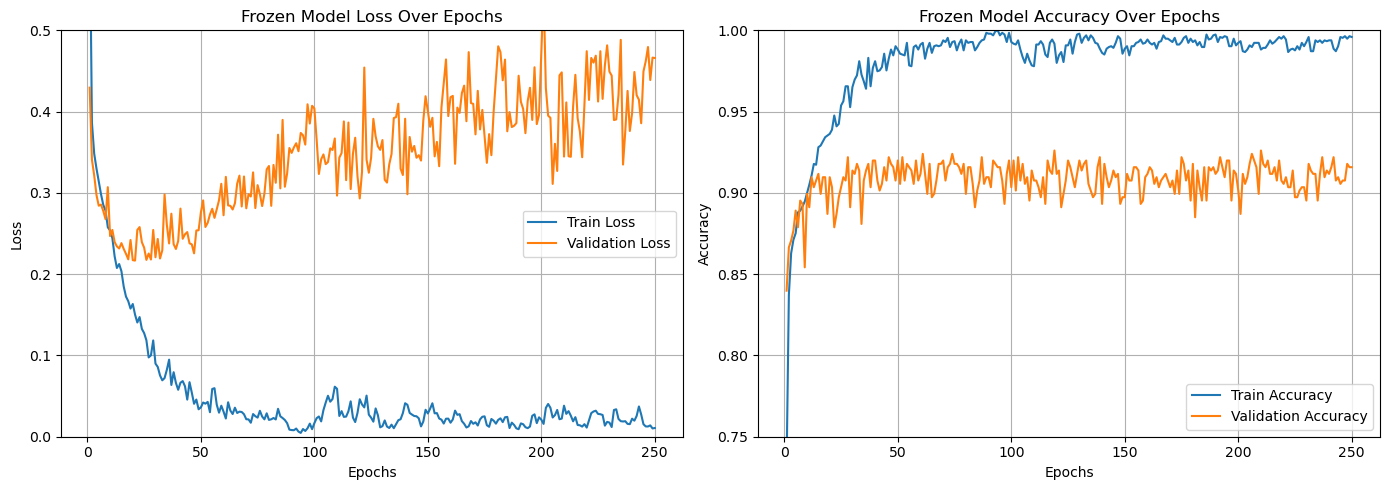

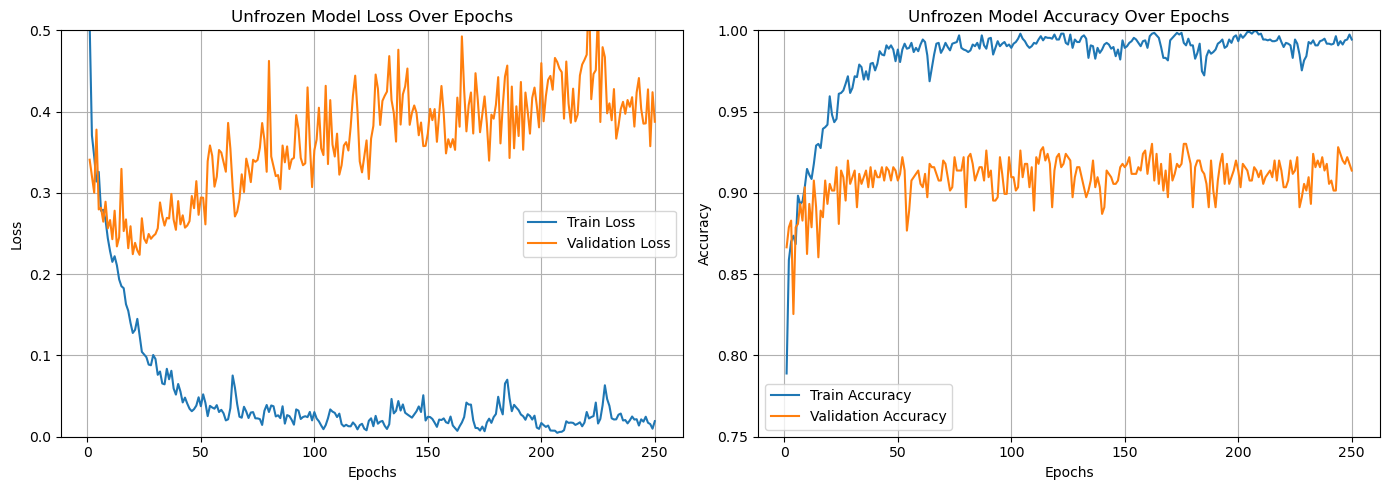


Final Metrics:
Frozen Model - Best Val Acc: 0.9261
Unfrozen Model - Best Val Acc: 0.9302


In [24]:
import matplotlib.pyplot as plt

# Plot training and validation metrics for both models
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0.0, 0.5)
    plt.legend()
    plt.grid()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.75, 1.0)  # Set y-axis limits for accuracy
    plt.legend()
    plt.grid()

    # Display plots
    plt.tight_layout()
    plt.show()

# Plot metrics for the frozen model
plot_metrics(
    train_losses_frozen, val_losses_frozen,
    train_accuracies_frozen, val_accuracies_frozen,
    "Frozen Model"
)

# Plot metrics for the unfrozen model
plot_metrics(
    train_losses_unfrozen, val_losses_unfrozen,
    train_accuracies_unfrozen, val_accuracies_unfrozen,
    "Unfrozen Model"
)

# Print final metrics
print("\nFinal Metrics:")
print(f"Frozen Model - Best Val Acc: {best_val_acc_frozen:.4f}")
print(f"Unfrozen Model - Best Val Acc: {best_val_acc_unfrozen:.4f}")


/tmp/ipykernel_1135/344691835.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_frozen.load_state_dict(torch.load('best_Dino_Model_Frozen3.pth', map_location=device

Evaluating Frozen Model
Test Loss: 0.3483, Test Acc: 0.9187, Test AUC: 0.9169


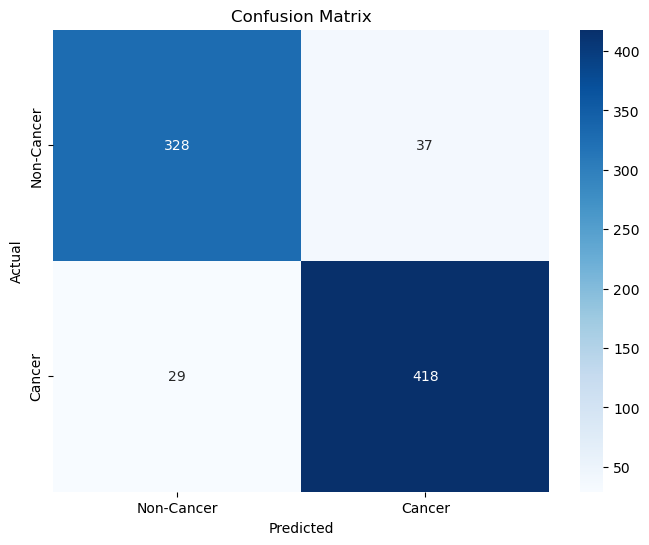


Evaluating Unfrozen Model
Test Loss: 0.3428, Test Acc: 0.9273, Test AUC: 0.9237


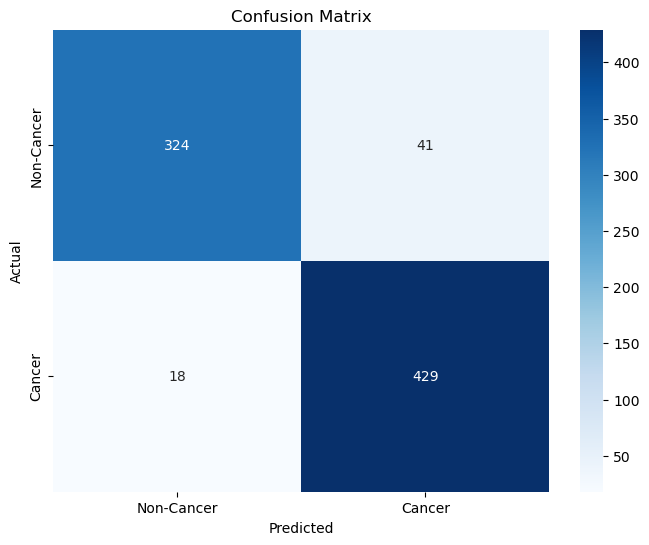

(0.9273399014778325, 0.9237013882504366)

In [26]:
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the feature extractor for frozen and unfrozen models
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Define the model architectures
model_frozen = DINOClassifier(dinov2_model=feature_extractor).to(device)
model_unfrozen = DINOClassifier(dinov2_model=AutoModel.from_pretrained('facebook/dinov2-base')).to(device)

# Load the saved state dictionaries
model_frozen.load_state_dict(torch.load('best_Dino_Model_Frozen3.pth', map_location=device))
model_unfrozen.load_state_dict(torch.load('best_Dino_Model_Unfrozen3.pth', map_location=device))

# Set models to evaluation mode
model_frozen.eval()
model_unfrozen.eval()

# Evaluation function
def evaluate_on_test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            correct_predictions += (predictions == labels).sum().item()

    test_acc = correct_predictions / len(test_dataset)
    test_auc = roc_auc_score(y_true, y_pred)

    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}")
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'], yticklabels=['Non-Cancer', 'Cancer'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return test_acc, test_auc

# Evaluate the frozen model
print("Evaluating Frozen Model")
evaluate_on_test(model_frozen, test_loader, criterion)

# Evaluate the unfrozen model
print("\nEvaluating Unfrozen Model")
evaluate_on_test(model_unfrozen, test_loader, criterion)


/tmp/ipykernel_1135/453620326.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_frozen.load_state_dict(torch.load('best_Dino_Model_Frozen2.pth', map_location=device

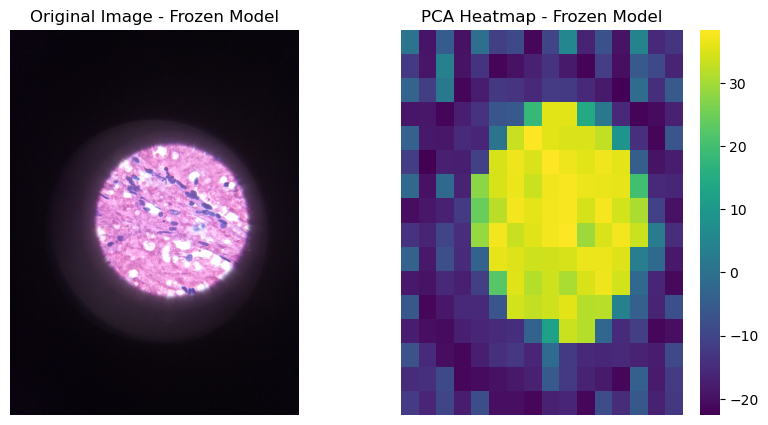

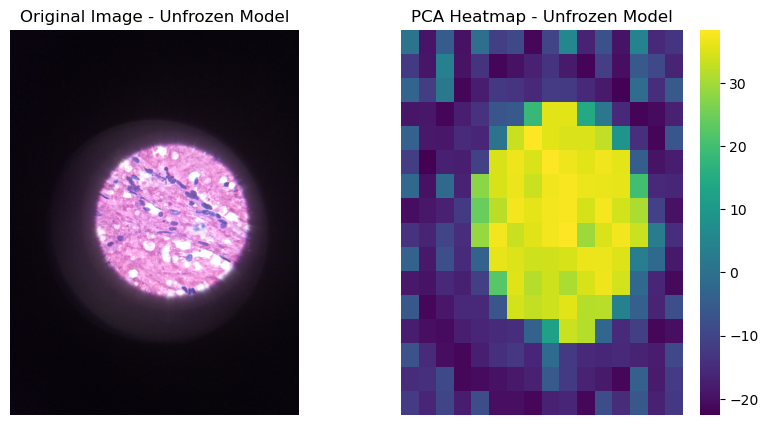

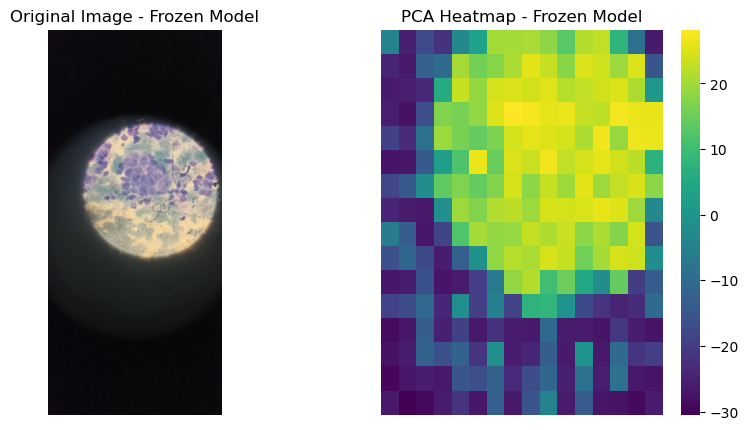

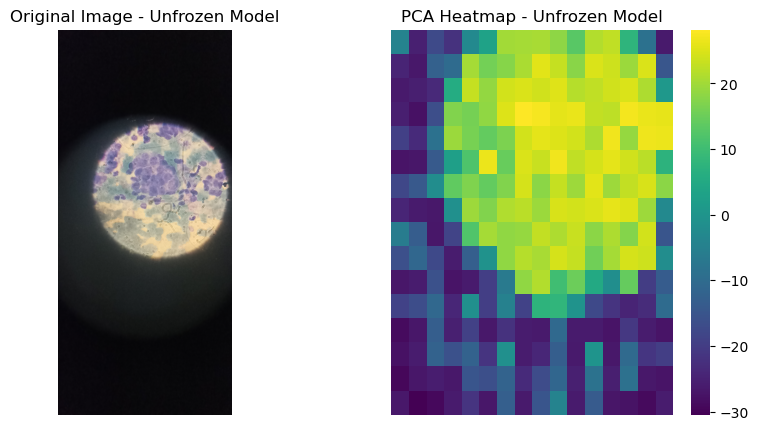

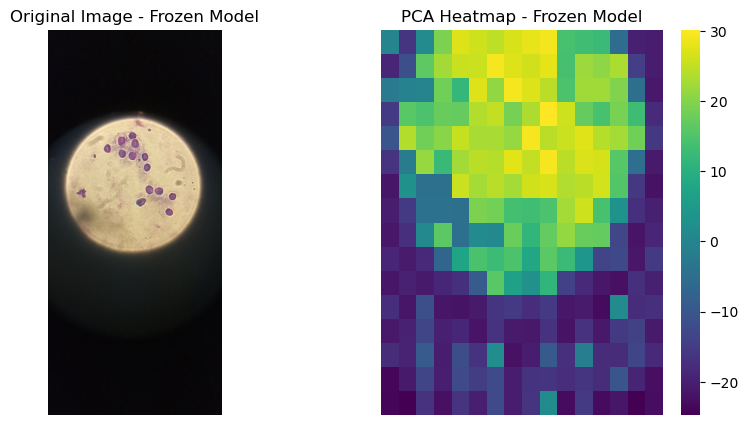

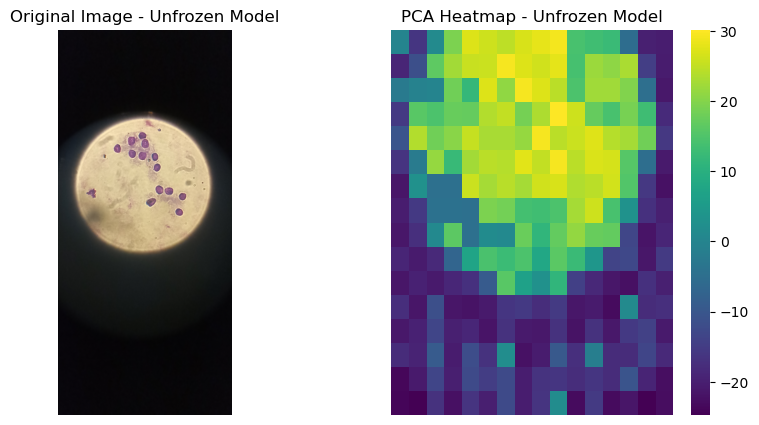

In [22]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the feature extractor for frozen and unfrozen models
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Define the model architectures
model_frozen = DINOClassifier(dinov2_model=feature_extractor).to(device)
model_unfrozen = DINOClassifier(dinov2_model=AutoModel.from_pretrained('facebook/dinov2-base')).to(device)

# Load the saved state dictionaries
model_frozen.load_state_dict(torch.load('best_Dino_Model_Frozen2.pth', map_location=device))
model_unfrozen.load_state_dict(torch.load('best_Dino_Model_Unfrozen2.pth', map_location=device))

# Set models to evaluation mode
model_frozen.eval()
model_unfrozen.eval()

# PCA heatmap generator
def generate_pca_heatmap2D(model, processor, image_path, model_name, device, num_components=2):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    processed = processor(images=image, return_tensors="pt")
    input_image = processed['pixel_values'].to(device)

    # Extract features from the model
    model.eval()
    with torch.no_grad():
        features = model.feature_extractor(input_image).last_hidden_state.squeeze(0).cpu().numpy()  # Shape: (seq_len, hidden_dim)

    # Exclude CLS token
    features = features[1:, :]  # Remove the first token (CLS token)

    # Flatten features for PCA
    seq_len, hidden_dim = features.shape
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(features)  # Shape: (seq_len, num_components)

    # Reshape PCA output back into a spatial heatmap
    spatial_dim = int(seq_len ** 0.5)  # Assuming square spatial grid
    if spatial_dim * spatial_dim != seq_len:
        raise ValueError(f"Feature map is not square after removing CLS token: seq_len={seq_len}")
    heatmap_data = pca_result[:, 0].reshape(spatial_dim, spatial_dim)

    # Plot the original image and the heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Image - {model_name}")

    plt.subplot(1, 2, 2)
    sns.heatmap(heatmap_data, cmap="viridis", cbar=True)
    plt.title(f"PCA Heatmap - {model_name}")
    plt.axis('off')
    plt.show()



# Test PCA heatmap generation
test_images = test_df['image_path'].sample(3).values  # Select 3 random test images

for img_path in test_images:
    full_image_path = os.path.join(base_image_path, img_path.replace('\\', '/'))
    generate_pca_heatmap2D(model_frozen, processor, full_image_path, "Frozen Model", device)
    generate_pca_heatmap2D(model_unfrozen, processor, full_image_path, "Unfrozen Model", device)


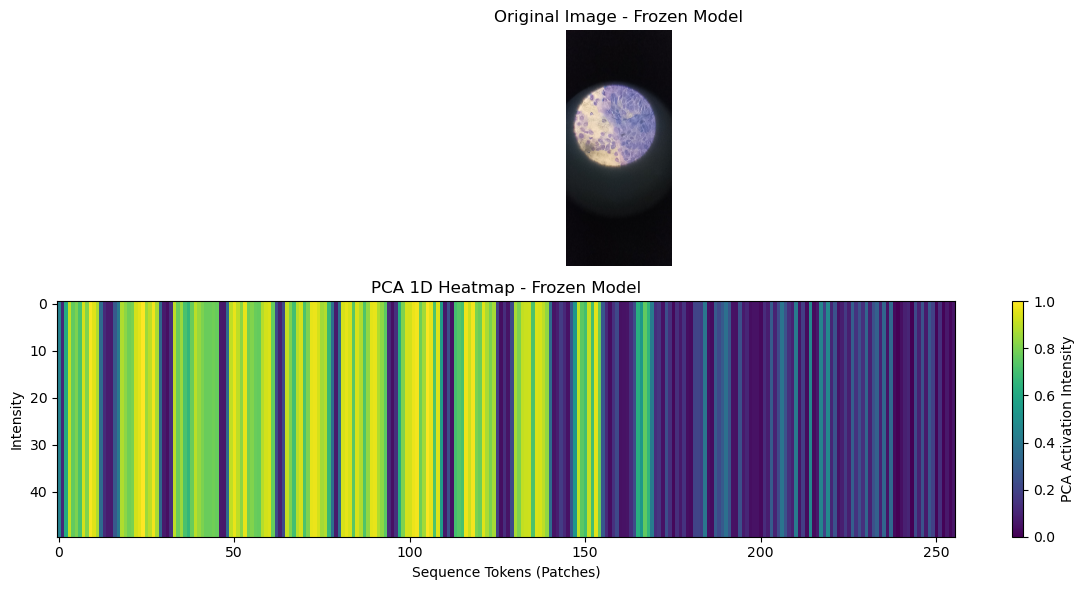

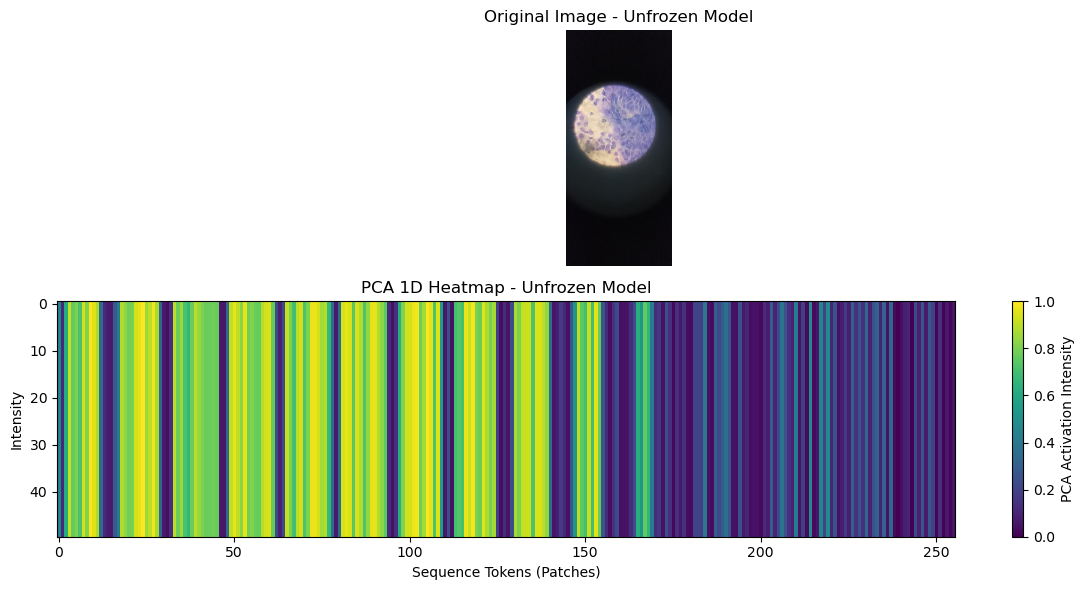

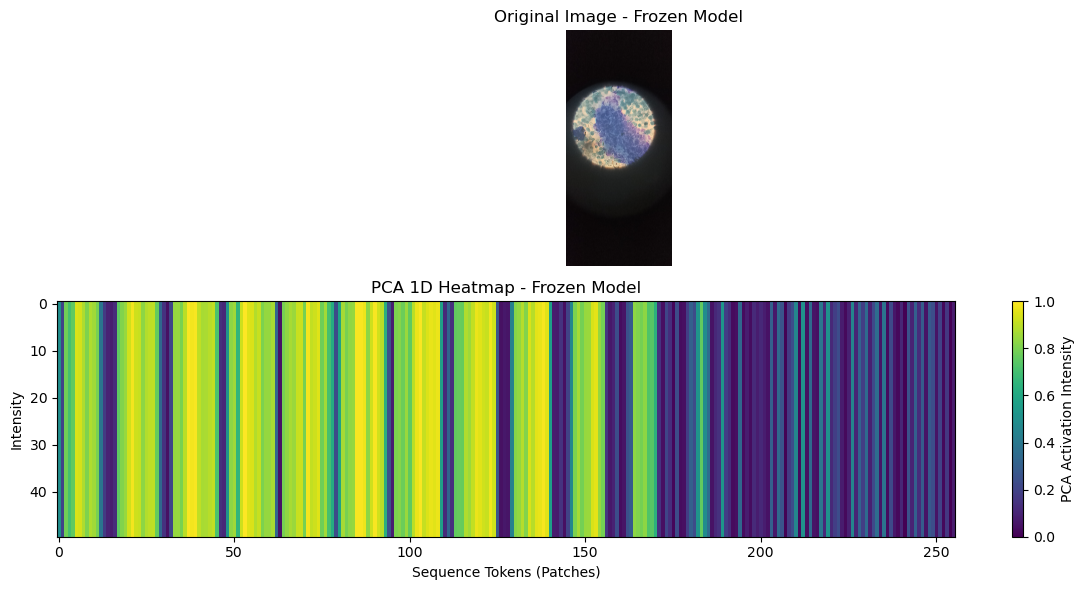

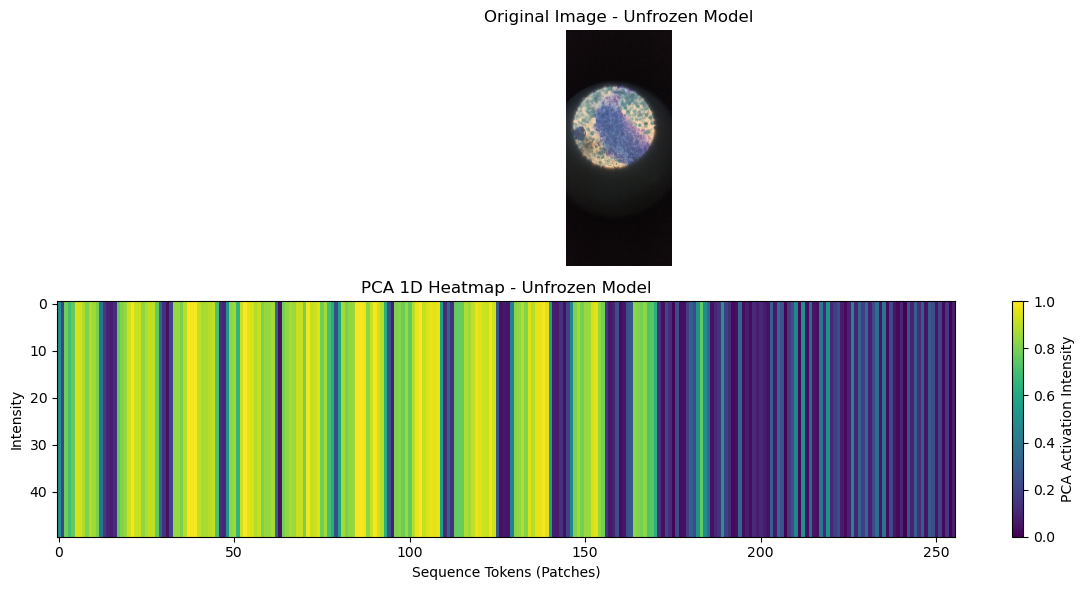

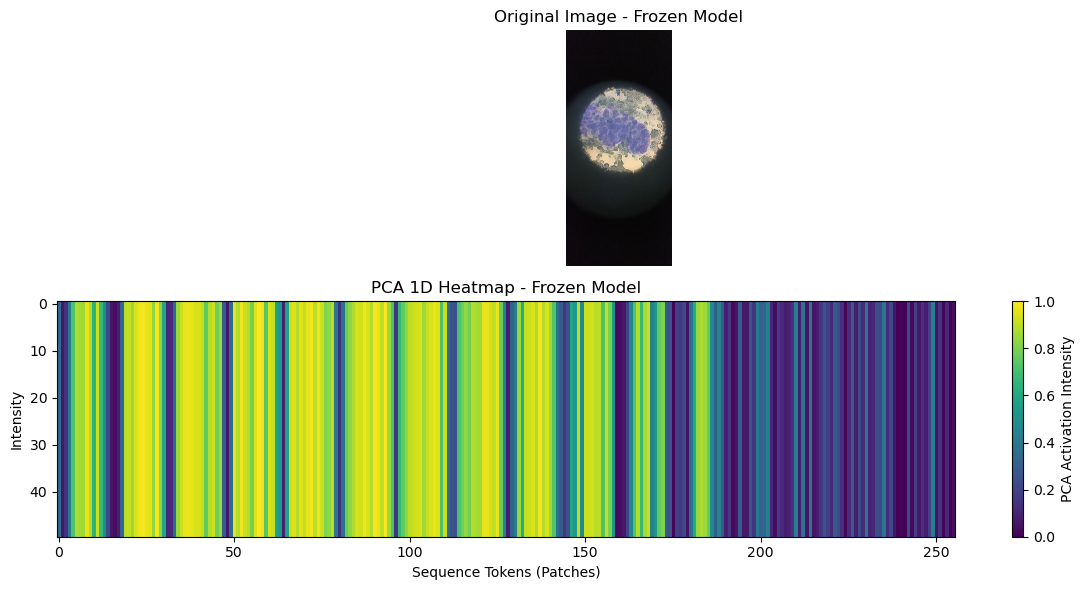

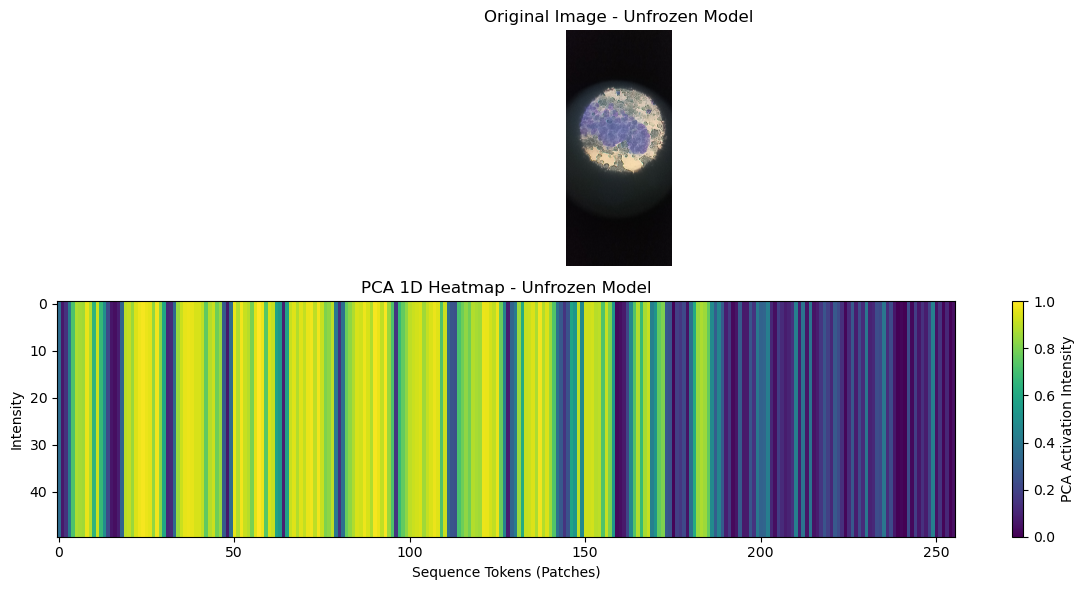

In [ ]:
def generate_pca_1d_heatmap(model, processor, image_path, model_name, device, num_components=2):
    image = Image.open(image_path).convert('RGB')
    processed = processor(images=image, return_tensors="pt")
    input_image = processed['pixel_values'].to(device)

    # Extract features from the model
    model.eval()
    with torch.no_grad():
        features = model.feature_extractor(input_image).last_hidden_state.squeeze(0).cpu().numpy()  # Shape: (seq_len, hidden_dim)

    # Exclude CLS token
    features = features[1:, :]  # Remove the first token (CLS token)

    # Flatten features for PCA
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(features)  # Shape: (seq_len, num_components)

    # Take the first principal component for the 1D representation
    pca_1d = pca_result[:, 0]  # Shape: (seq_len,)

    # Normalize the PCA 1D output for visualization
    pca_1d_normalized = (pca_1d - np.min(pca_1d)) / (np.max(pca_1d) - np.min(pca_1d))  # Scale to [0, 1]

    # Convert 1D PCA into a 2D heatmap (1D row repeated for visualization)
    heatmap_2d = np.tile(pca_1d_normalized, (50, 1))  # Shape: (50, seq_len)

    # Plot the original image and the 1D PCA heatmap
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Image - {model_name}")

    plt.subplot(2, 1, 2)
    plt.imshow(heatmap_2d, cmap="viridis", aspect="auto")
    plt.colorbar(label="PCA Activation Intensity")
    plt.title(f"PCA 1D Heatmap - {model_name}")
    plt.xlabel("Sequence Tokens (Patches)")
    plt.ylabel("Intensity")
    plt.tight_layout()
    plt.show()
for img_path in test_images:
    full_image_path = os.path.join(base_image_path, img_path.replace('\\', '/'))
    generate_pca_1d_heatmap(model_frozen, processor, full_image_path, "Frozen Model", device)
    generate_pca_1d_heatmap(model_unfrozen, processor, full_image_path, "Unfrozen Model", device)


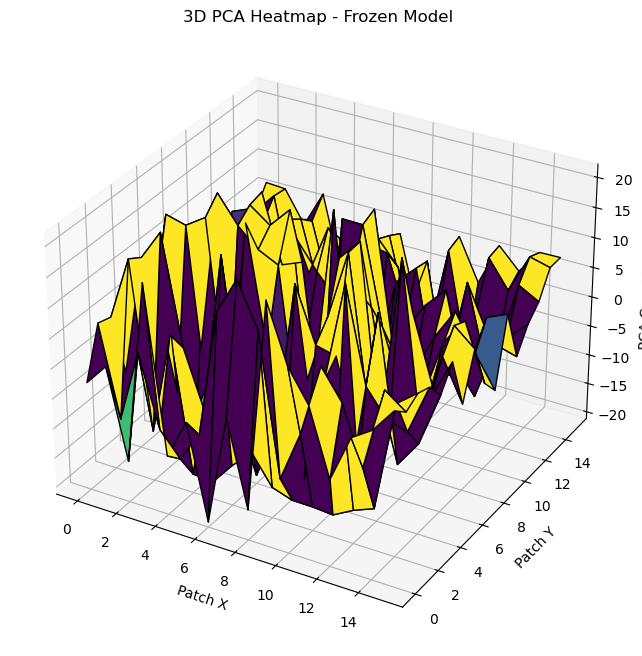

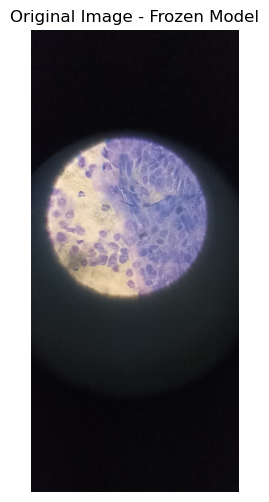

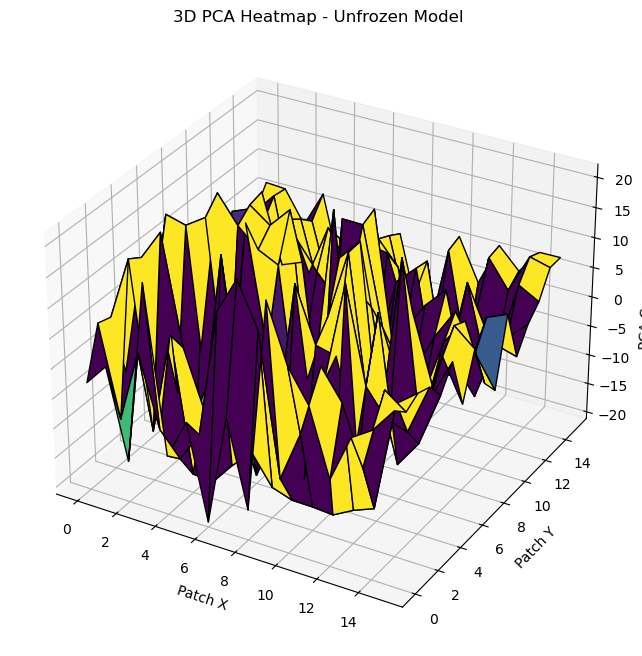

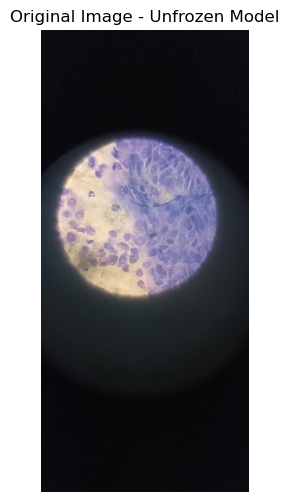

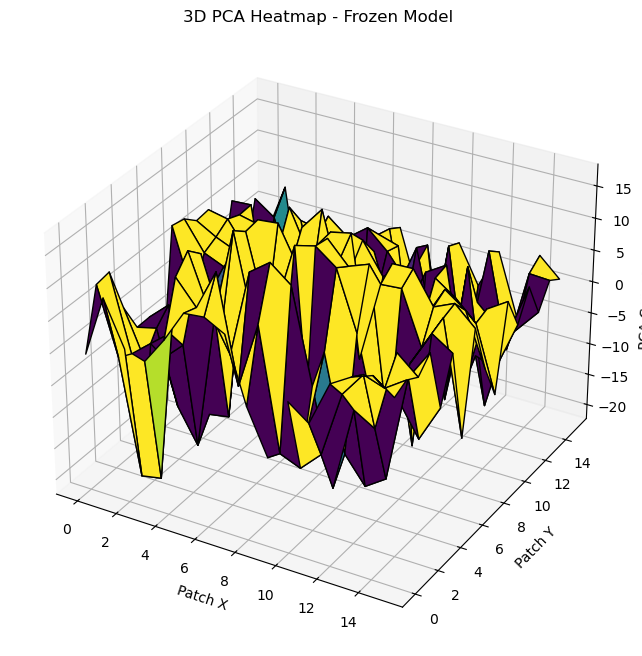

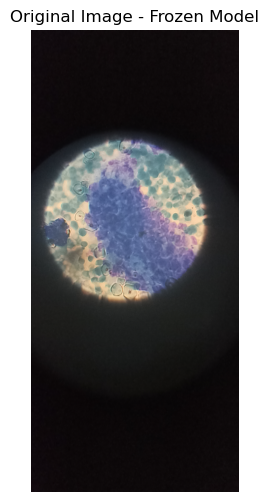

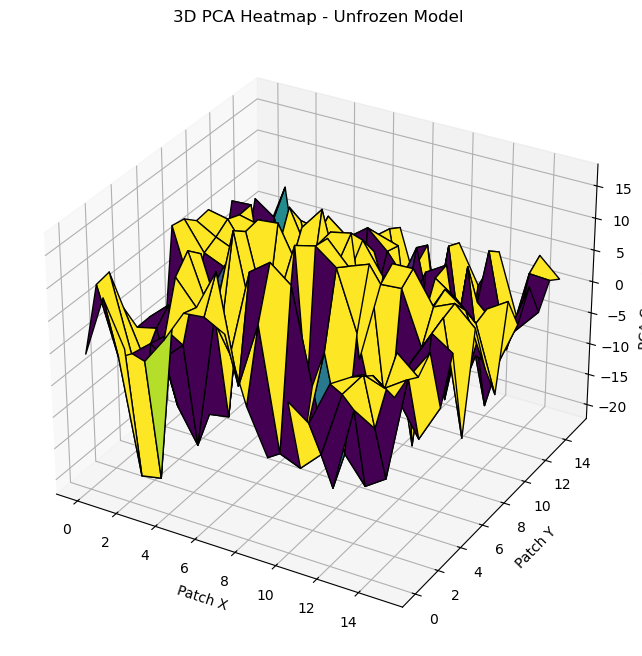

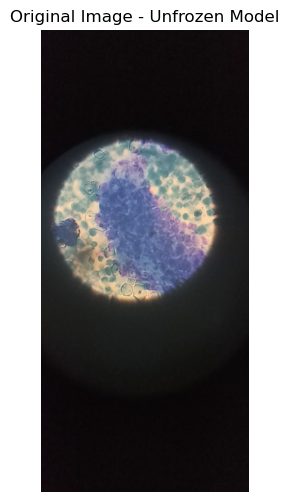

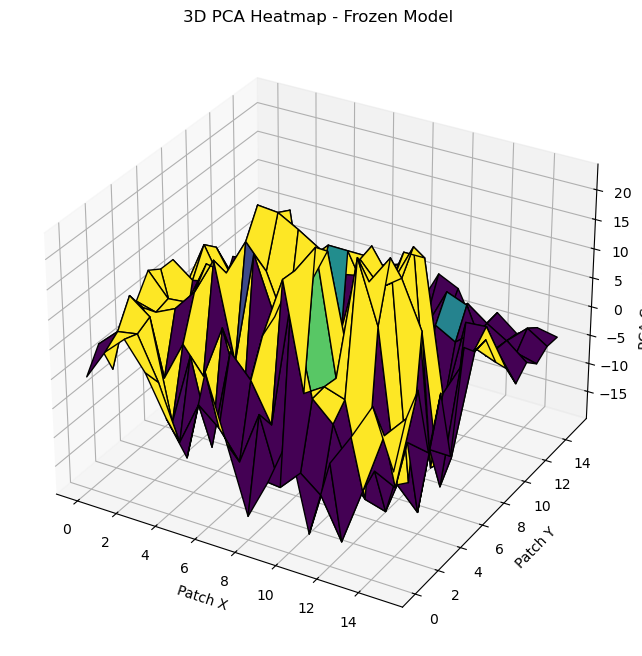

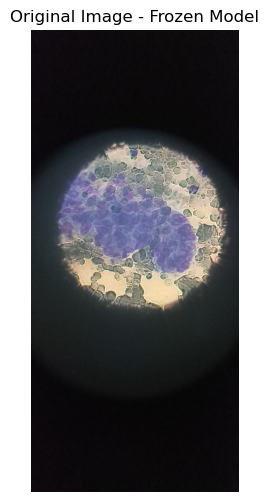

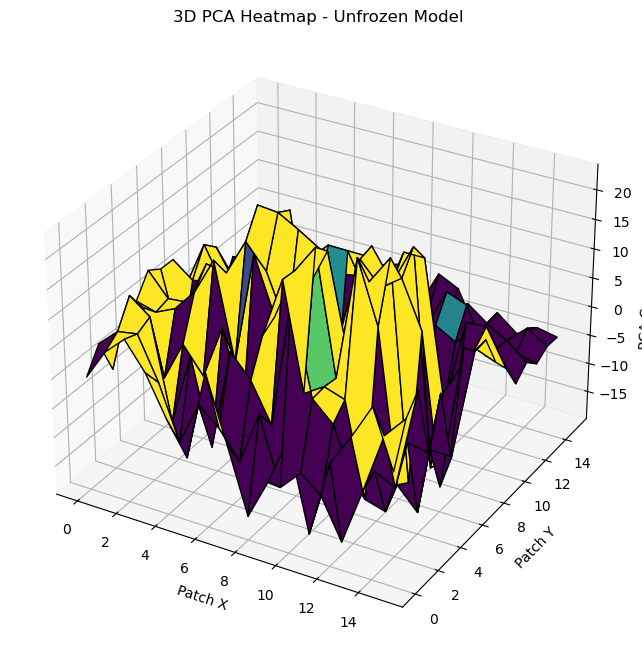

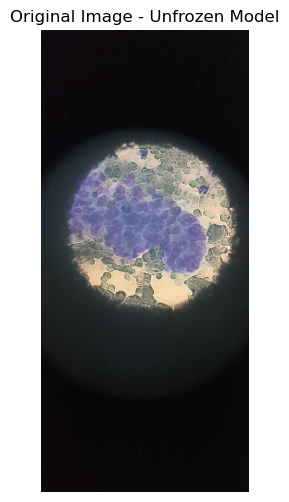

In [50]:
from mpl_toolkits.mplot3d import Axes3D

def generate_pca_3d_heatmap(model, processor, image_path, model_name, device, num_components=3):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    processed = processor(images=image, return_tensors="pt")
    input_image = processed['pixel_values'].to(device)

    # Extract features from the model
    model.eval()
    with torch.no_grad():
        features = model.feature_extractor(input_image).last_hidden_state.squeeze(0).cpu().numpy()  # Shape: (seq_len, hidden_dim)

    # Exclude CLS token
    features = features[1:, :]  # Remove the first token (CLS token)

    # Perform PCA to reduce to 3 components
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(features)  # Shape: (seq_len, num_components)

    # Assume the spatial dimensions of the patches
    seq_len = pca_result.shape[0]
    spatial_dim = int(seq_len ** 0.5)  # Square root to get the spatial grid
    if spatial_dim * spatial_dim != seq_len:
        raise ValueError(f"Feature map is not square: seq_len={seq_len}")

    # Reshape the first three PCA components into spatial grids
    pca_3d_x = pca_result[:, 0].reshape(spatial_dim, spatial_dim)  # First component
    pca_3d_y = pca_result[:, 1].reshape(spatial_dim, spatial_dim)  # Second component
    pca_3d_z = pca_result[:, 2].reshape(spatial_dim, spatial_dim)  # Third component

    # Create 3D surface plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(spatial_dim), np.arange(spatial_dim))
    ax.plot_surface(X, Y, pca_3d_z, facecolors=plt.cm.viridis(pca_3d_z), cmap="viridis", edgecolor='k')
    ax.set_title(f"3D PCA Heatmap - {model_name}")
    ax.set_xlabel("Patch X")
    ax.set_ylabel("Patch Y")
    ax.set_zlabel("PCA Component Z")
    plt.show()

    # Also display the original image for reference
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Image - {model_name}")
    plt.show()
for img_path in test_images:
    full_image_path = os.path.join(base_image_path, img_path.replace('\\', '/'))
    generate_pca_3d_heatmap(model_frozen, processor, full_image_path, "Frozen Model", device)
    generate_pca_3d_heatmap(model_unfrozen, processor, full_image_path, "Unfrozen Model", device)
